In [12]:
#Process docking results and correlate RMSD with chemical features of molecules
#11/13/23 added an update- Spearman correlation
#Hoping to obtain a file of protein features/P-L complex features, which can also be correlated with RMSD
#11/28/23 add on binding site info and nearby water info
#12/1/23 work with HarmonicFlow results as well
#compare HarmonicFlow and DiffDock results
#Compare HarmonicFlow inference and PDBBind 3d metrics
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy import stats

In [13]:
results_d = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/TEST3_top40_epoch75_FILTER_restart_cacheNewRestart_big_ema_ESM2emb_tr34_WITH_fixedSamples28_id1_FILTERFROM_temp_restart_ema_ESM2emb_tr34"

In [14]:
#From Hannes
with open(f'{results_d}/complex_names.npy', 'rb') as f:
    complex_names = np.load(f)
with open(f'{results_d}/rmsds.npy', 'rb') as f:
    rmsds = np.load(f)
with open(f'{results_d}/confidences.npy', 'rb') as f:
    confidences = np.load(f)
    
#Dina adds 11/28/23 info on protein binding site chemistry
with open('/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Site_Comp_231128/Binding_site_composition_Cutoff_3.7.npy', 'rb') as f:
    bsite_comp = np.load(f, allow_pickle = True)
    
with open('/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Site_Comp_231128/Nearby_W_Cutoff_3.7.npy', 'rb') as f:
    w_info = np.load(f, allow_pickle = True)

In [37]:
#Add 12/1 obtain unique pdbs and their rmsds- averaging see Hannes 11/14 Slack message
hf_results_d = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output"
hf_metrics = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv"
df_hf = pd.read_csv(hf_metrics)
unique_pdbs = list(set(df_hf["pred_name"]))
hf_rmsd_dict = {}
for pdb_unique in unique_pdbs:
    hf_rmsd_dict[pdb_unique] = np.average(df_hf[df_hf["pred_name"] == pdb_unique]["pred_rmsd"])
print(hf_rmsd_dict)

#Dina adds 12/1/23 for HF bound waters and protein residues

#Dina adds 11/28/23 info on protein binding site chemistry
with open('/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Site_Comp_231128/Binding_site_composition_HF_Cutoff_3.7.npy', 'rb') as f:
    bsite_comp_hf = np.load(f, allow_pickle = True)
    
with open('/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Site_Comp_231128/Nearby_W_Cutoff_HF_3.7.npy', 'rb') as f:
    w_info_hf = np.load(f, allow_pickle = True)

{'6mo7': 2.19879738, '6qts': 7.2566584800000005, '6qlq': 3.1144013100000003, '6hhg': 7.92595833, '6mhc': 1.6375753759999998, '6n96': 5.057563180000001, '6eeb': 2.46259339, '6s55': 7.858149870000001, '6inz': 0.9480061689999999, '6nrj': 2.5481872700000006, '6gge': 1.42579877, '6ibz': 2.62061994, '6oy2': 0.9900653549999999, '6jam': 3.11777353, '6os6': 1.5192759399999998, '6od6': 0.576329118, '6sen': 12.4059502, '6oxs': 0.9051093809999999, '6g2f': 5.59816386, '6uii': 1.7274502999999999, '6h9v': 2.84985116, '6uvv': 0.661580705, '6oin': 7.16964016, '6st3': 1.65801225, '6pnn': 3.41025858, '6gj6': 5.22778699, '6oxy': 0.9718408719999999, '6olx': 1.70722513, '6qr3': 1.58140554, '6oir': 6.11437739, '6hza': 9.409237050000002, '6hhh': 2.4795564499999996, '6npm': 1.37840737, '6fe5': 0.99618207, '6qtw': 9.123709850000001, '6mo8': 3.8501146, '6e3o': 1.050605657, '6hzb': 9.403710149999998, '5zml': 7.132962050000001, '6rtn': 1.33123344, '6d3z': 10.600038089999998, '6qqw': 1.8403231300000003, '6jib': 2.2

In [95]:
len(rmsds[0])

40

In [96]:
len(confidences[0])

40

In [97]:
len(complex_names)

363

In [98]:
complex_names

array(['6qqw', '6d08', '6jap', '6np2', '6uvp', '6oxq', '6jsn', '6hzb',
       '6qrc', '6oio', '6jag', '6moa', '6hld', '6i9a', '6e4c', '6g24',
       '6jb4', '6s55', '6seo', '6dyz', '5zk5', '6jid', '5ze6', '6qlu',
       '6a6k', '6qgf', '6e3z', '6te6', '6pka', '6g2o', '6jsf', '5zxk',
       '6qxd', '6n97', '6jt3', '6qtr', '6oy1', '6n96', '6qzh', '6qqz',
       '6qmt', '6ibx', '6hmt', '5zk7', '6k3l', '6cjs', '6n9l', '6ibz',
       '6ott', '6gge', '6hot', '6e3p', '6md6', '6hlb', '6fe5', '6uwp',
       '6npp', '6g2f', '6mo7', '6bqd', '6nsv', '6i76', '6n53', '6g2c',
       '6eeb', '6n0m', '6uvy', '6ovz', '6olx', '6v5l', '6hhg', '5zcu',
       '6dz2', '6mjq', '6efk', '6s9w', '6gdy', '6kqi', '6ueg', '6oxt',
       '6oy0', '6qr7', '6i41', '6cyg', '6qmr', '6g27', '6ggb', '6g3c',
       '6n4e', '6fcj', '6quv', '6iql', '6i74', '6qr4', '6rnu', '6jib',
       '6izq', '6qw8', '6qto', '6qrd', '6hza', '6e5s', '6dz3', '6e6w',
       '6cyh', '5zlf', '6om4', '6gga', '6pgp', '6qqv', '6qtq', '6gj6',
      

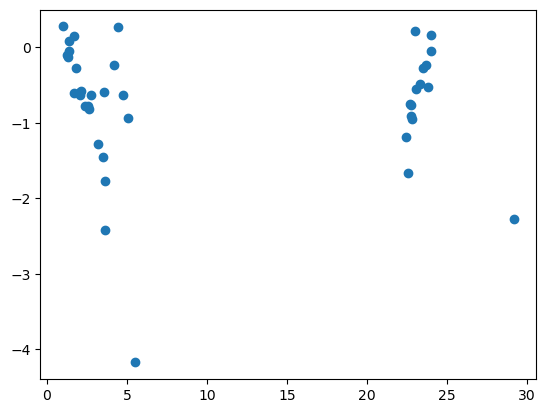

In [99]:
plt.scatter(rmsds[0], confidences[0])

In [17]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [100]:
#Plot df correlation
#Inputs:
#(a) df_plot df with data to plot
#(b) metrics_plot which metrics to plot
#(c) s_hf harmonicflow string
def plot_df(df_plot, metrics_plot, s_hf):
    
    if s_hf == "DiffDock":
        cplot = [0.9, 0.6, 0.6]
        
    if s_hf == "HarmonicFlow":
        cplot = [0.6, 0.6, 0.9]
    
    #Scatterplot, histogram, R2 calc for each metric
    pltlist = ["PctHeteroatoms", "CountHeteroatoms", "TPSA", "CountAllAtoms", "CountAliphaticRings", "CountAliphaticRingsNorm", "LogP", "Rg", "Asph", "KD", "NearbyW"]

    if s_hf == "HarmonicFlow":
        pltlist += ["Rg_PDB_Minus_Inf", "Asph_PDB_Minus_Inf"]
    #iterate over metrics
    for p in pltlist:
        fp, ap = plt.subplots()
        plt.scatter(df_plot[p], df_plot["top_rmsd"], alpha = 0.7, color = cplot)
        plt.xlabel(p, fontsize = 20)
        plt.ylabel("RMSD (Å)", fontsize = 20)
        if p == "CountAliphaticRingsNorm":
            plt.xticks(fontsize = 14)
        else:
            plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        spearman_r = scipy.stats.spearmanr(df_plot[p], df_plot["top_rmsd"])
        plt.title(s_hf, fontsize = 20)
        #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
        #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
        plt.text(1.02, 0.88, f"Spearman R : {spearman_r[0]:.3f}\np-value : {spearman_r[1]:.3e}", transform=ap.transAxes, fontsize = 16)
        plt.show()
        plt.close()

        #split histogram. by rmsd
        less_than_2 = df_plot[df_plot["top_rmsd"] < 2][p]
        greater_than_2 = df_plot[df_plot["top_rmsd"] >= 2][p]
        plt.hist(less_than_2, color = [0.1, 0.2, 0.9], label = "Under 2", alpha = 0.5)
        plt.hist(greater_than_2, color = [0.9, 0.2, 0.1], label = "Above 2", alpha = 0.5)
        plt.xlabel(p)
        plt.title(s_hf, fontsize = 20)
        plt.legend()
        plt.show()
        plt.close()

        print(scipy.stats.pearsonr(df_plot[p], df_plot["top_rmsd"]))
        #spearman thank you Jeremy for the suggestion!
        #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
        print(scipy.stats.spearmanr(df_plot[p], df_plot["top_rmsd"]))
        #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
        #TODO- is this the correct test?
        print(scipy.stats.ttest_ind(less_than_2, greater_than_2))

In [55]:
#Analyze binding site composition
#Input:
#(a) bind_site_df dataframe for binding site
#(b) st_hf is this a HarmonicFlow run?
def analyze_binding_site(bind_site_df,
                         st_hf):
    #Chi square test
    binding_site_dictionary = {"under_2" : {},
                               "over_2" : {}}

    list_aas = ["ALA", 
                   "CYS", 
                   "ASP", 
                   "GLU",
                   "PHE", 
                   "GLY", 
                   "HIS", 
                   "ILE", 
                   "LYS", 
                   "LEU", 
                   "MET", 
                   "ASN", 
                   "PRO", 
                   "GLN", 
                   "ARG", 
                   "SER",
                   "THR",
                   "VAL",
                   "TRP",
                   "TYR"]
    #Names from Ref https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html
    for rmsdk in binding_site_dictionary.keys():
        for aa in list_aas:
            binding_site_dictionary[rmsdk][aa] = 0

    #Iterate over data frame
    for df_entry in range(0, len(bind_site_df)): #range(0, len(df_pdb)):
        #print(f"entry {df_entry}")
        #print(f"rmsd {df_pdb['names'][df_entry]}")
        #print(f"rmsd {df_pdb['top_rmsd'][df_entry]}")
        #print(f"residues {df_pdb['Residues'][df_entry]}")

        if bind_site_df["top_rmsd"][df_entry] >= 2.0:
            key_use = "over_2"
        else:
            key_use = "under_2"

        for aa_add in bind_site_df["Residues"][df_entry]:
            if aa_add != "MSE": #maybe add back in?
                binding_site_dictionary[key_use][aa_add] += 1
        #print(binding_site_dictionary)
        
    #Significance test of aa differences
    #Ref https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets
    #Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
    under_2_list = [binding_site_dictionary["under_2"][a] for a in list_aas]
    over_2_list = [binding_site_dictionary["over_2"][a] for a in list_aas]
    summed_list = [binding_site_dictionary["under_2"][a] + binding_site_dictionary["over_2"][a] for a in list_aas]

    #Normalized list
    norm_u_2 = 1000.0 * np.array(under_2_list) / np.sum(under_2_list)
    norm_o_2 = 1000.0 * np.array(over_2_list) / np.sum(over_2_list)

    #Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
    #But different overall counts
    print(scipy.stats.chisquare(norm_u_2, norm_o_2))
    print(scipy.stats.chisquare(norm_o_2, norm_u_2))
    print(stats.ks_2samp(under_2_list, over_2_list))

    #Does aa chemistry affect partitioning?
    print("AA Under 2 freq Over 2 freq Multiplier")
    aa_dict_of_mult = {}
    for aa in sorted(list_aas):
        print(f"{aa} {binding_site_dictionary['under_2'][aa]} {binding_site_dictionary['over_2'][aa]} {binding_site_dictionary['under_2'][aa] / binding_site_dictionary['over_2'][aa] : .2f}")
        aa_dict_of_mult[aa] = binding_site_dictionary['under_2'][aa] / binding_site_dictionary['over_2'][aa]

    #Ref https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html
    kd_dict = {"ALA" : 1.8,
    "CYS" : 2.5,
    "ASP" : -3.5,
    "GLU" : -3.5,
    "PHE" : 2.8,
    "GLY" : -0.4,
    "HIS" : -3.2,
    "ILE" : 4.5,
    "LYS" : -3.9,
    "LEU" : 3.8,
    "MET" : 1.9,
    "ASN" : -3.5,
    "PRO" : -1.6,
    "GLN" : -3.5,
    "ARG" : -4.5,
    "SER" : -0.8,
    "THR" : -0.7,
    "VAL" : 4.2,
    "TRP" : -0.9,
    "TYR" : -1.3}

    atom_count_dict = {"ALA" : 1,
    "CYS" : 2,
    "ASP" : 4,
    "GLU" : 5,
    "PHE" : 7,
    "GLY" : 0,
    "HIS" : 6,
    "ILE" : 4,
    "LYS" : 5,
    "LEU" : 4,
    "MET" : 4,
    "ASN" : 4,
    "PRO" : 3,
    "GLN" : 5,
    "ARG" : 7,
    "SER" : 2,
    "THR" : 3,
    "VAL" : 3,
    "TRP" : 10,
    "TYR" : 8}

    kd_list = []
    ac_list = []
    mult_list = []
    kd_list_no_gly = []
    mult_list_no_gly = []

    for aa_pl in list_aas:
        kd_list.append(kd_dict[aa_pl])
        ac_list.append(atom_count_dict[aa_pl])
        mult_list.append(aa_dict_of_mult[aa_pl])
        if aa_pl != "GLY":
            kd_list_no_gly.append(kd_dict[aa_pl])
            mult_list_no_gly.append(aa_dict_of_mult[aa_pl])


    afh, aph = plt.subplots()
    plt.scatter(kd_list, mult_list, color = [0.1, 0.9, 0.7])


    #spearman thank you Jeremy for the suggestion!
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    #plt.title("all, KD")
    plt.xlabel("Amino Acid KD", fontsize = 20)
    plt.ylabel("Ratio", fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.title(st_hf, fontsize = 20)
    print(scipy.stats.spearmanr(kd_list, mult_list))
    spearman_r_kd = scipy.stats.spearmanr(kd_list, mult_list)
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    plt.text(1.02, 0.88, f"Spearman R : {spearman_r_kd[0]:.3f}\np-value : {spearman_r_kd[1]:.3e}", transform=aph.transAxes, fontsize = 16)


    plt.show()
    plt.close()
    plt.clf()
    plt.cla()


    ataf, atap = plt.subplots()

    plt.scatter(ac_list, mult_list, color = [0.1, 0.9, 0.7])


    plt.xlabel("Amino Acid Side Chain Heavy Atom Count", fontsize = 20)
    plt.ylabel("Ratio", fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    #spearman thank you Jeremy for the suggestion!
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    #plt.title("atom count")
    spearman_r_ac = scipy.stats.spearmanr(ac_list, mult_list)
    plt.title(st_hf, fontsize = 20)
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    plt.text(1.02, 0.88, f"Spearman R : {spearman_r_ac[0]:.3f}\np-value : {spearman_r_ac[1]:.3e}", transform=atap.transAxes, fontsize = 16)

    plt.show()
    plt.close()
    plt.clf()
    plt.cla()

    plt.scatter(kd_list_no_gly, mult_list_no_gly, color = [0.1, 0.9, 0.7])
    plt.title(st_hf, fontsize = 20)
    #spearman thank you Jeremy for the suggestion!
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    print(scipy.stats.spearmanr(kd_list_no_gly, mult_list_no_gly))
    plt.title("No Glycine, KDD")
    plt.xlabel("KD")
    plt.ylabel("Multiplier")
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()


In [101]:
#Make dataframe of pdb ids and rmsds
#Inputs:
#(a) name_info names of pdbs. None if using HF results
#(b) rmsd_info rmsds. None if using HF results
#(c) confidence_info confidences for each rmsd. None if using HF results
#(d) pdbpath path to PDBBind structures
#(e) bsite_cd binding site info dictionary
#(f) w_info_d water info dictionary
#(g) hf_info_d HarmonicFlow dictionary. None if using DiffDock results
#(h) hf_structures_d directory of HF structures
#Output:
#pd_df ddataframe with RMSD results and info on each complex
def create_df(name_info, rmsd_info, confidence_info, pdbpath, bsite_cd, w_info_d, hf_info_d, hf_structures_d):
    
    #12/1/23 add option for working with hf results
    if hf_info_d is None:
        name_list = name_info
        top_rmsd_list = []
        top_confidence_list = []

        #ID top confidence rmsd
        #Hannes code helped a lot
        for rmsd_for_pdb, conf_for_pdb in zip(rmsd_info, confidence_info):
            #print("NEW")
            #print(f"max confidence {max(conf_for_pdb)}")

            #Get ranked confidences and associate rmsds for each confidence
            #Ref https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
            conf_ordered = np.argsort(conf_for_pdb)
            #print("ordered and conf")
            #print(conf_ordered)
            #print(conf_for_pdb)
            #print("confidences in order")
            #print(conf_for_pdb[conf_ordered])
            #print("rmsd by confidence")
            #print(rmsd_for_pdb[conf_ordered])
            #for ci, cv in zip(sorted(conf_ordered), conf_for_pdb):
            #    print(f"{ci} rank val is {cv[ci]}")
            #    print(cv[])

            top_rmsd_list.append(rmsd_for_pdb[conf_ordered][-1])
            top_confidence_list.append(conf_for_pdb[conf_ordered][-1])

            #Pull ligand info
            #ligand_path = ""
            
    else:
        name_list = list(hf_info_d.keys())
        top_rmsd_list = [hf_info_d[k_rmsd] for k_rmsd in name_list]

    
    #Lists of props ffor df
    ligand_smiles = []
    logp = []
    heteroatompct = []
    heteroatomcount = []
    tpsa = []
    numaliphaticrings = []
    numaliphaticringsnorm = []
    allatomcount = []
    rg = []
    asph = []
    kd_value = []
    bsite_res = []
    waters = []
    
    if hf_structures_d is not None:
        rg_diff = []
        asph_diff = []
    
    #Pull sdf/mol2 and then smiles
    for ip, pdb_name in enumerate(name_list):
        print(f"On {ip}")
        #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
        for file in os.listdir(os.path.join(pdbpath, pdb_name)):
            if file.endswith(".sdf") and 'rdkit' not in file:
                lig = read_molecule(os.path.join(pdbpath, pdb_name, file), remove_hs=False, sanitize=True)
                if lig is None and os.path.exists(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                    print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                    lig = read_molecule(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)
                
                #Process molecule
                #Ref https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors
                #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html#module-rdkit.Chem.Descriptors
                #Ref https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors
                #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
                #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html
                if lig is not None: 
                    ligand_smiles.append(Chem.MolToSmiles(lig))
                    logp.append(Descriptors.MolLogP(lig))
                    heteroatompct.append(float(Descriptors.NumHeteroatoms(lig)) / float(Descriptors.HeavyAtomCount(lig)))
                    heteroatomcount.append(float(Descriptors.NumHeteroatoms(lig)))
                    numaliphaticrings.append(Descriptors.NumAliphaticRings(lig))  
                    numaliphaticringsnorm.append(float(Descriptors.NumAliphaticRings(lig)) / float(Descriptors.HeavyAtomCount(lig)))
                    allatomcount.append(Descriptors.HeavyAtomCount(lig))
                    tpsa.append(Descriptors.TPSA(lig))
                    l_xtal_rg = rdkit.Chem.Descriptors3D.RadiusOfGyration(lig)
                    rg.append(l_xtal_rg)
                    l_xtal_asph = rdkit.Chem.Descriptors3D.Asphericity(lig)
                    asph.append(l_xtal_asph)
                else:
                    ligand_smiles.append("NOSMILESSTRING")
                    logp.append("NOLOGP")
                    heteroatompct.append("NODATA")
                    
        #Now get inference ligand Rg and asph 12/1/23
        #TODO is sanitize false ok????
        if hf_structures_d is not None:
            for file in os.listdir(hf_structures_d):
                if file.endswith(f"{pdb_name}_x20.pdb"):
                    lig_inference = read_molecule(os.path.join(hf_structures_d, file), remove_hs=False, sanitize=False)
                    #print(lig_inference)
                    l_inf_rg = rdkit.Chem.Descriptors3D.RadiusOfGyration(lig_inference)
                    l_inf_asph = rdkit.Chem.Descriptors3D.Asphericity(lig_inference)
                    l_rg_diff = l_xtal_rg - l_inf_rg
                    l_asph_diff = l_xtal_asph - l_inf_asph
                    rg_diff.append(l_rg_diff)
                    asph_diff.append(l_asph_diff)
                    print(l_inf_rg)
                        
        #11/28/23 add on binding site information
        kd_value.append(bsite_cd[pdb_name]["average_kd"])
        bsite_res.append(bsite_cd[pdb_name]["residues"])
        waters.append(w_info_d[pdb_name])
    
    #Create dict, df
    dict_of_molec_info = {"names" : name_info,
                          "top_rmsd" : top_rmsd_list,
                          "ligand_smiles" : ligand_smiles, 
                          "LogP" : logp,
                          "PctHeteroatoms" : heteroatompct,
                          "CountHeteroatoms" : heteroatomcount,
                          "CountAllAtoms" : allatomcount,
                          "CountAliphaticRings" : numaliphaticrings,
                          "CountAliphaticRingsNorm" : numaliphaticringsnorm,
                          "TPSA" : tpsa,
                          "Rg" : rg,
                          "Asph" : asph,
                          "KD" : kd_value,
                          "Residues" : bsite_res,
                          "NearbyW" : waters,
                          "Rg_PDB_Minus_Inf" : rg_diff,
                          "Asph_PDB_Minus_Inf" : asph_diff}
    
    
    
    if hf_info_d is None:
        dict_of_molec_info["top_confidence"] = top_confidence_list
        hf_str = "DiffDock"
    else:
        hf_str = "HarmonicFlow"
        
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
    pd_df = pd.DataFrame(data = dict_of_molec_info)
    
    plot_df(pd_df,
            ["PctHeteroatoms", "CountHeteroatoms", "TPSA", "CountAllAtoms", "CountAliphaticRings", "CountAliphaticRingsNorm", "LogP", "Rg", "Asph", "KD", "NearbyW"],
           hf_str)
    
    analyze_binding_site(pd_df, hf_str)
    
    return pd_df

In [84]:
#Plot for multiple methods
#(a) m1df df for method 1
#(b) m2df df for method 2
#(c) m1name first method name
#(d) m2name second method name
#(e) mplot metric plot
def plot_multiple_methods(m1df, m2df, m1name, m2name, mplot):
    #Scatterplot, histogram, R2 calc for each metric
    pltlist = ["PctHeteroatoms", "CountHeteroatoms", "TPSA", "CountAllAtoms", "CountAliphaticRings", "CountAliphaticRingsNorm", "LogP", "Rg", "Asph", "KD", "NearbyW"]

    #iterate over metrics
    for p in pltlist:
    
        ataf, atap = plt.subplots()


        plt.scatter(m1df[p], m1df["top_rmsd"], color = [0.9, 0.6, 0.6], label = m1name, alpha = 0.7)
        plt.scatter(m2df[p], m2df["top_rmsd"], color = [0.6, 0.6, 0.9], label = m2name, alpha = 0.7)


        plt.yticks(fontsize = 20)
        if p == "CountAliphaticRingsNorm":
            plt.xticks(fontsize = 14)
        else:
            plt.xticks(fontsize = 20)
        plt.xlabel(p, fontsize = 20)
        plt.ylabel("RMSD (Å)", fontsize = 20)
        #spearman thank you Jeremy for the suggestion!
        #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
        #plt.title("atom count")
        spearman_r_1 = scipy.stats.spearmanr(m1df[p], m1df["top_rmsd"])
        spearman_r_2 = scipy.stats.spearmanr(m2df[p], m2df["top_rmsd"])
        plt.title(f"{m1name} and {m2name}", fontsize = 20)
        #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
        #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
        plt.text(1.02, 0.50, f"{m1name}\nSpearman R : {spearman_r_1[0]:.3f}\np-value : {spearman_r_1[1]:.3e}\n{m2name}\nSpearman R : {spearman_r_2[0]:.3f}\np-value : {spearman_r_2[1]:.3e}", transform=atap.transAxes, fontsize = 16)
        plt.legend(bbox_to_anchor = (1.02, 0.30), fontsize = 15)
        plt.show()
        plt.close()
        plt.clf()
        plt.cla()

In [85]:
bsite_comp.item()["6qqw"]

{'average_kd': -0.49375,
 'residues': ['SER',
  'ILE',
  'GLY',
  'TYR',
  'VAL',
  'LEU',
  'ASN',
  'GLY',
  'GLY',
  'ARG',
  'TYR',
  'GLU',
  'GLY',
  'PRO',
  'THR',
  'PRO']}

[12:27:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecu

[12:27:43] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 18 19
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 110 111
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28


Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit was unable to read the m

[12:27:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:27:43] Explicit valence for atom # 3 C, 6, is greater than permitted
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
[12:27:43] Explicit valence for atom # 0 C greater than permitted
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[12:27:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14


Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14


[12:27:44] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
[12:27:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:27:44] Can't kekulize mol.  Unkekulized ato

Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
RDKit was unable to read the 

[12:27:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[12:27:44] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32


Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
RDKit was unable to read

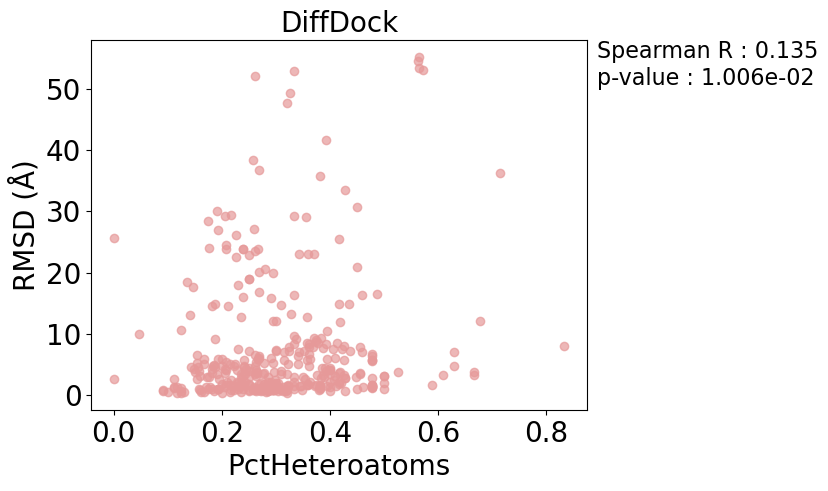

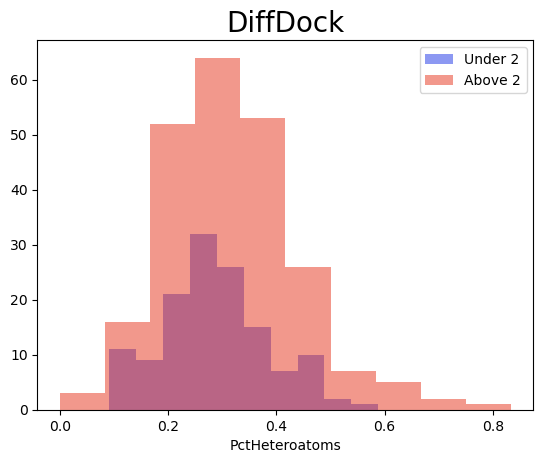

PearsonRResult(statistic=0.13252095252968857, pvalue=0.011493967193615945)
SignificanceResult(statistic=0.13492685416680636, pvalue=0.01006423834555343)
TtestResult(statistic=-2.2501559878983497, pvalue=0.025040655093081385, df=361.0)


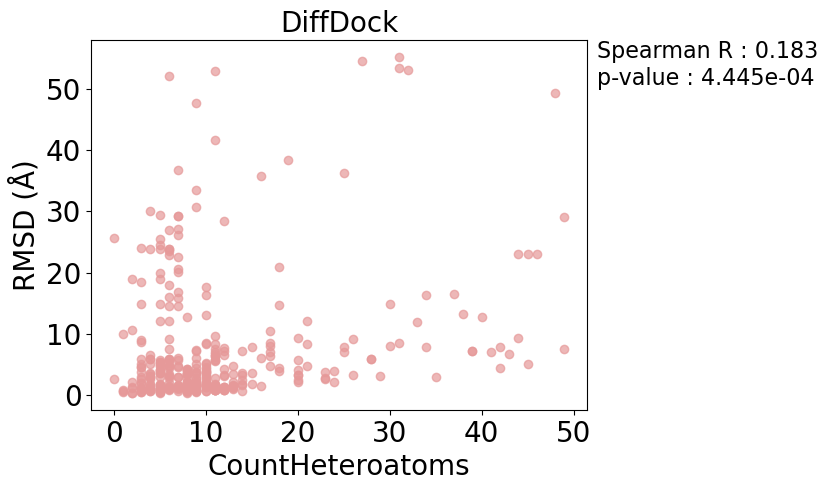

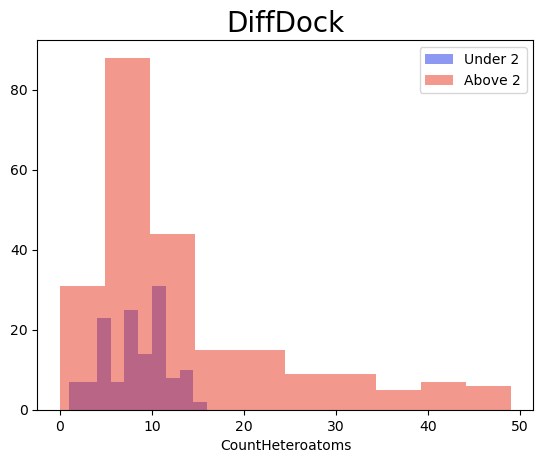

PearsonRResult(statistic=0.2504152809812254, pvalue=1.3530676680453815e-06)
SignificanceResult(statistic=0.18340791027930564, pvalue=0.0004444536763818364)
TtestResult(statistic=-5.187966085447186, pvalue=3.5527912678160007e-07, df=361.0)


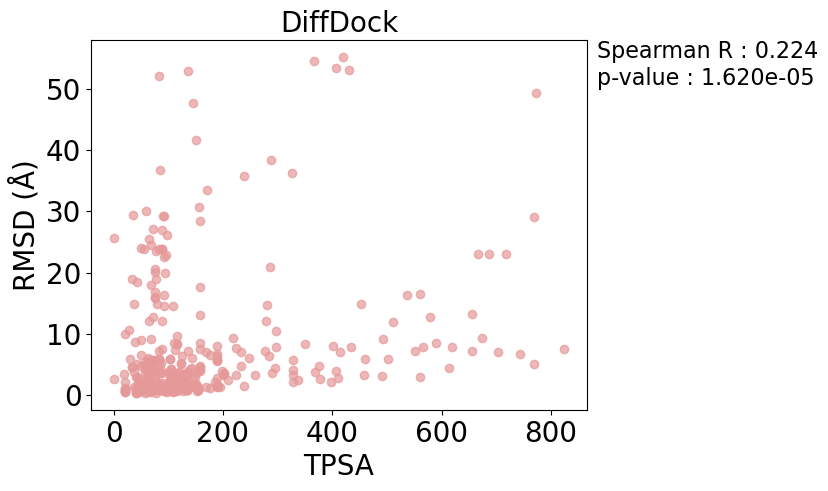

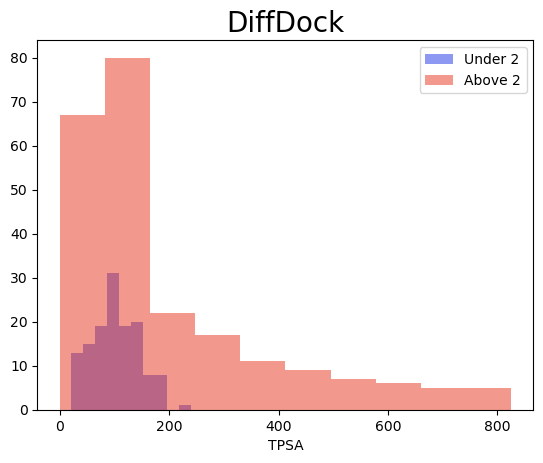

PearsonRResult(statistic=0.23760604692815257, pvalue=4.714573626536208e-06)
SignificanceResult(statistic=0.22418939795630302, pvalue=1.6203665752192236e-05)
TtestResult(statistic=-5.987110283727486, pvalue=5.158747439196019e-09, df=361.0)


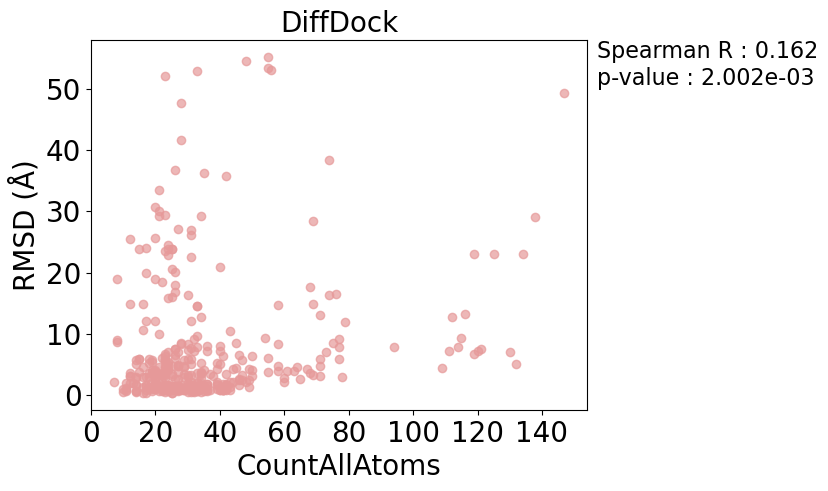

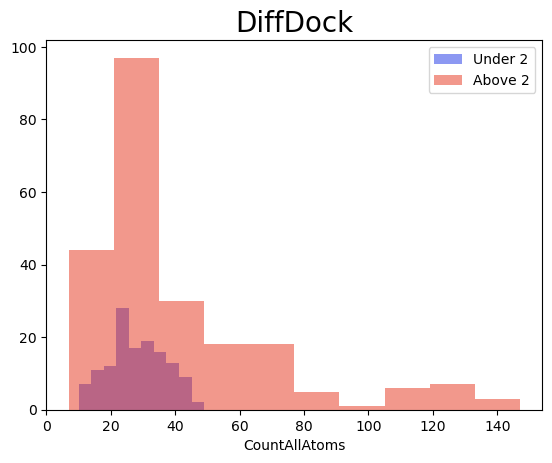

PearsonRResult(statistic=0.19744738579369608, pvalue=0.00015294238478744788)
SignificanceResult(statistic=0.1616687752263293, pvalue=0.002002028129997476)
TtestResult(statistic=-4.871081842066389, pvalue=1.6639119751991622e-06, df=361.0)


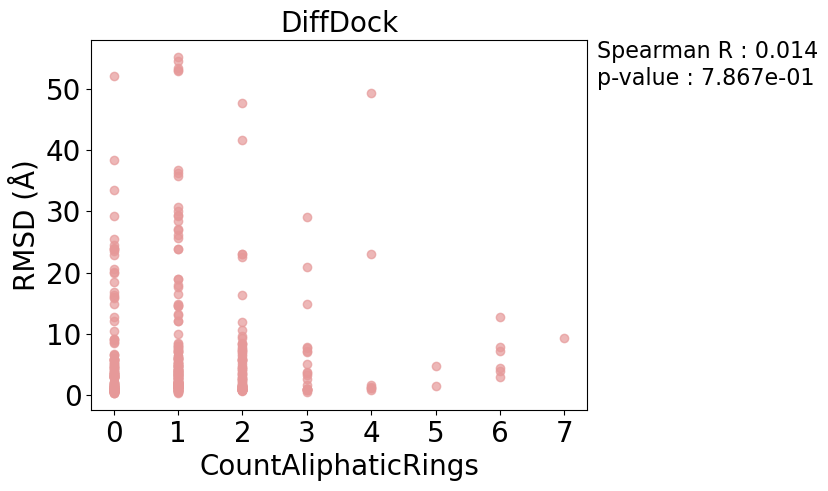

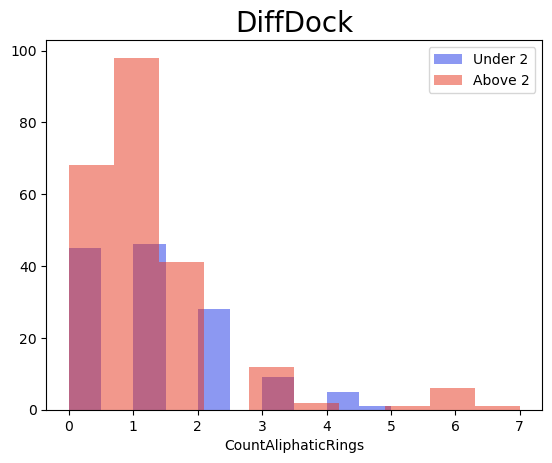

PearsonRResult(statistic=-0.017136068163472323, pvalue=0.7448906198584226)
SignificanceResult(statistic=0.01425366007973583, pvalue=0.7866634596764333)
TtestResult(statistic=-0.2906626704380987, pvalue=0.7714762328710565, df=361.0)


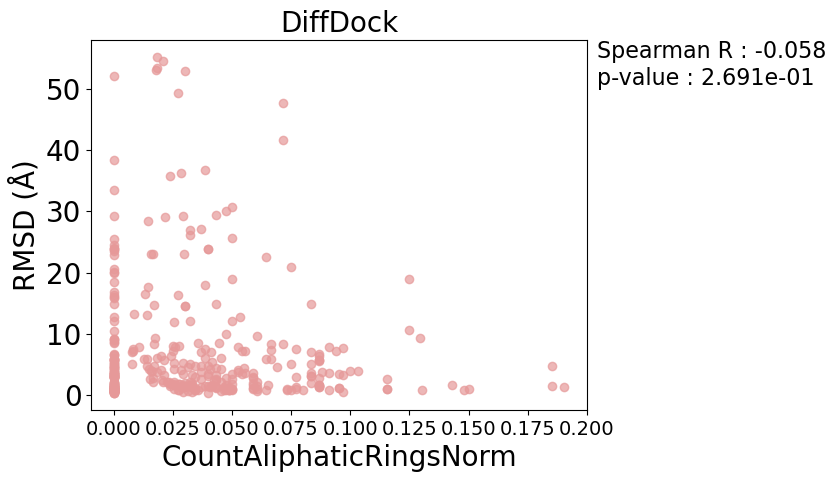

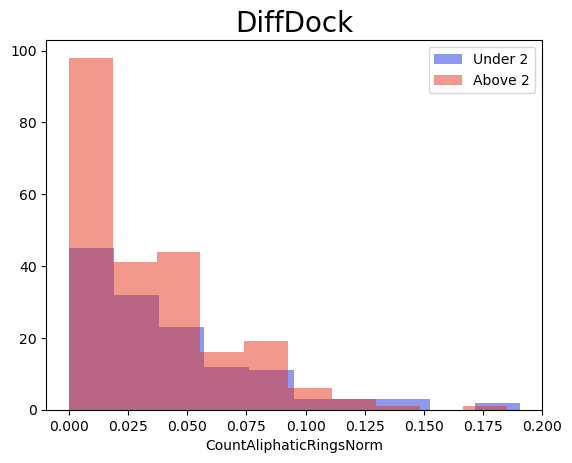

PearsonRResult(statistic=-0.10333163760327073, pvalue=0.0491589119999002)
SignificanceResult(statistic=-0.05815337003360341, pvalue=0.2691229512168707)
TtestResult(statistic=1.639496093646949, pvalue=0.10198108210289102, df=361.0)


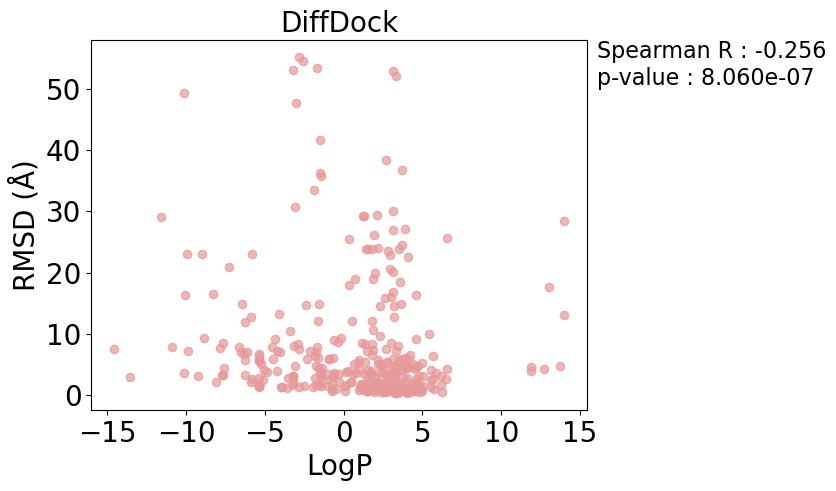

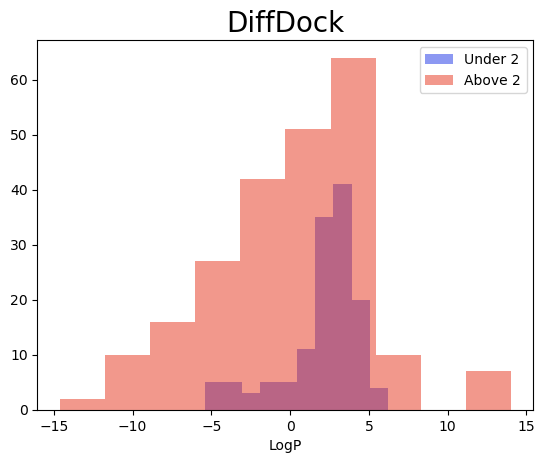

PearsonRResult(statistic=-0.1338831301277498, pvalue=0.010663883401532724)
SignificanceResult(statistic=-0.2555328536696331, pvalue=8.059771210818158e-07)
TtestResult(statistic=4.436551905512359, pvalue=1.2155301246775482e-05, df=361.0)


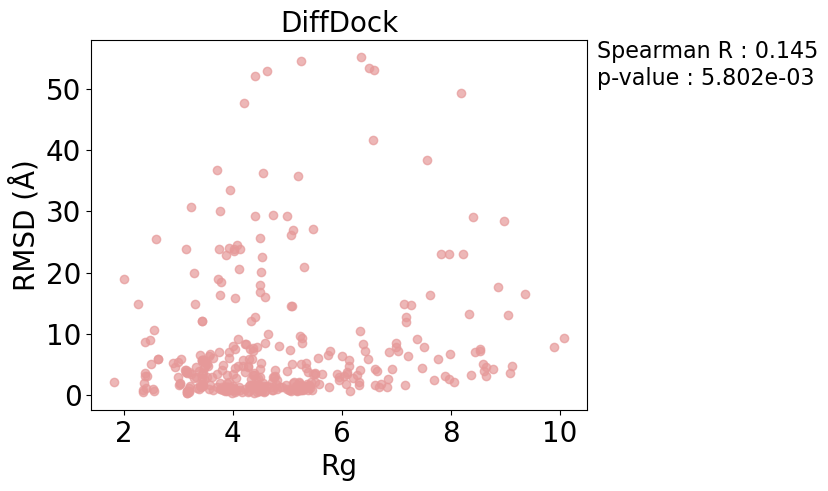

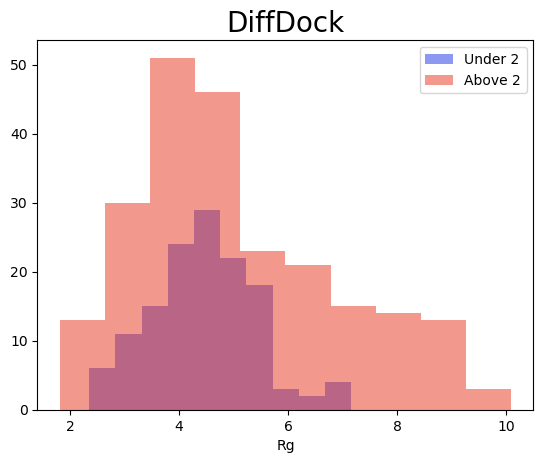

PearsonRResult(statistic=0.15126700221577613, pvalue=0.0038680890260342836)
SignificanceResult(statistic=0.14453452122964933, pvalue=0.005802207425505227)
TtestResult(statistic=-3.7330721051768703, pvalue=0.000219690173201465, df=361.0)


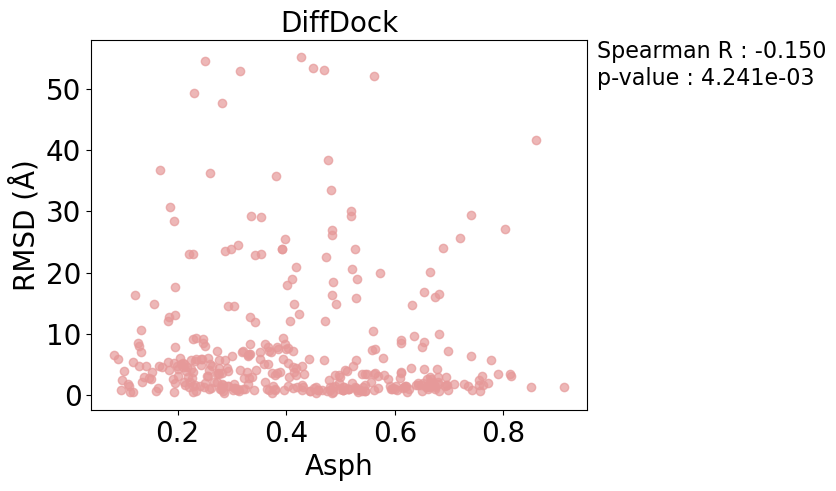

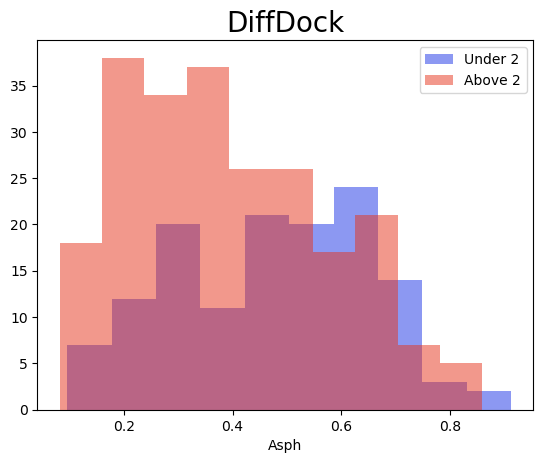

PearsonRResult(statistic=-0.044777962249843394, pvalue=0.39498100994124924)
SignificanceResult(statistic=-0.14976234212798753, pvalue=0.0042409651852841)
TtestResult(statistic=4.009241066108139, pvalue=7.403808864782215e-05, df=361.0)


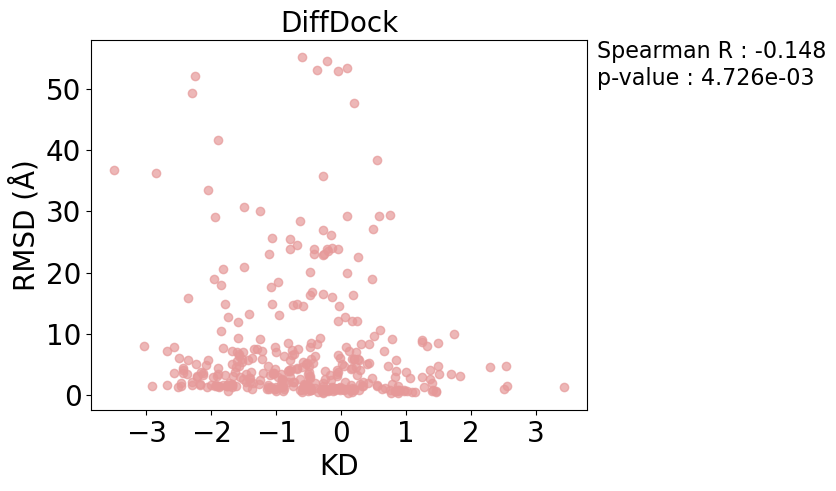

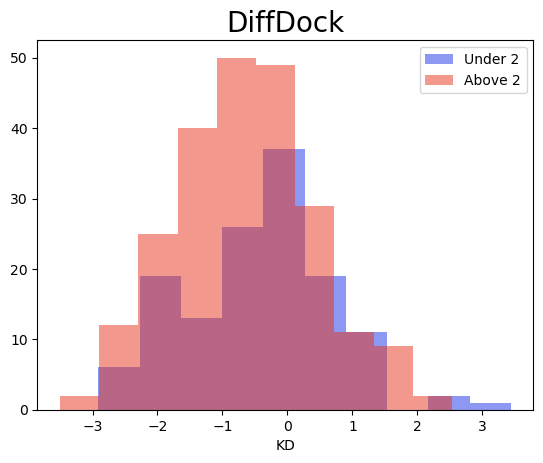

PearsonRResult(statistic=-0.08487872934439959, pvalue=0.10642029722474855)
SignificanceResult(statistic=-0.14797377277968968, pvalue=0.004726235624220402)
TtestResult(statistic=2.508572762056264, pvalue=0.012559700225537276, df=361.0)


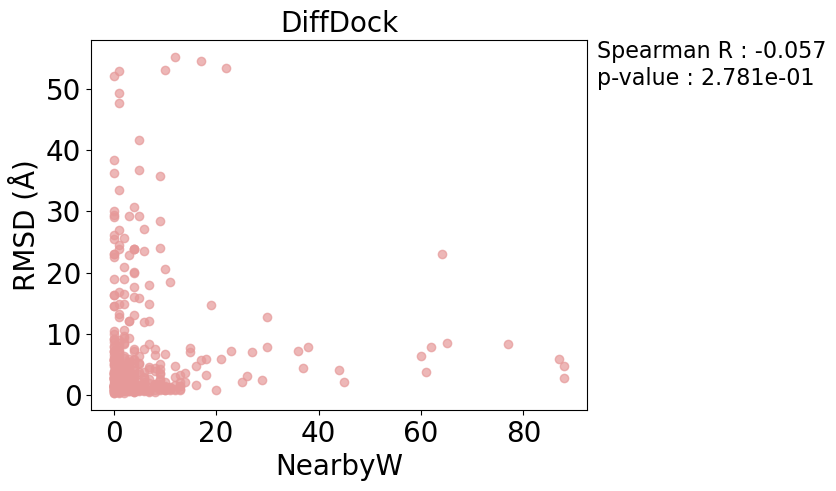

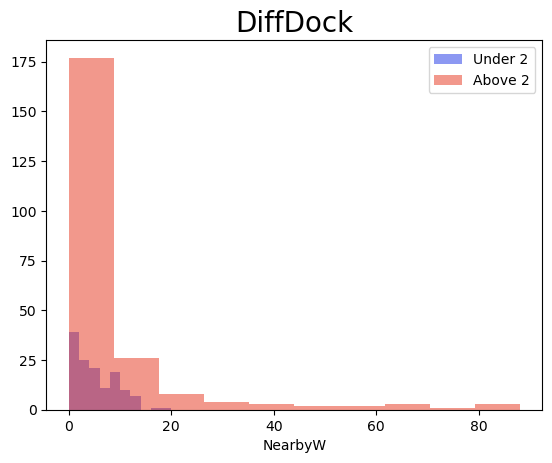

PearsonRResult(statistic=-0.006814884979816559, pvalue=0.8970453578623869)
SignificanceResult(statistic=-0.05707867709237952, pvalue=0.2780862008213676)
TtestResult(statistic=-2.4140720473106243, pvalue=0.016272252963015724, df=361.0)
Power_divergenceResult(statistic=112.97441604991707, pvalue=2.2499731928215436e-15)
Power_divergenceResult(statistic=119.12413694788145, pvalue=1.6168522399590598e-16)
KstestResult(statistic=0.8, pvalue=1.3259673752008224e-06, statistic_location=112, statistic_sign=1)
AA Under 2 freq Over 2 freq Multiplier
ALA 98 281  0.35
ARG 93 247  0.38
ASN 76 235  0.32
ASP 197 396  0.50
CYS 33 100  0.33
GLN 27 221  0.12
GLU 83 319  0.26
GLY 226 400  0.56
HIS 57 203  0.28
ILE 111 231  0.48
LEU 112 390  0.29
LYS 52 229  0.23
MET 49 107  0.46
PHE 73 286  0.26
PRO 56 193  0.29
SER 79 330  0.24
THR 74 296  0.25
TRP 48 195  0.25
TYR 99 350  0.28
VAL 100 326  0.31
SignificanceResult(statistic=0.25962449003498966, pvalue=0.2689837363861518)


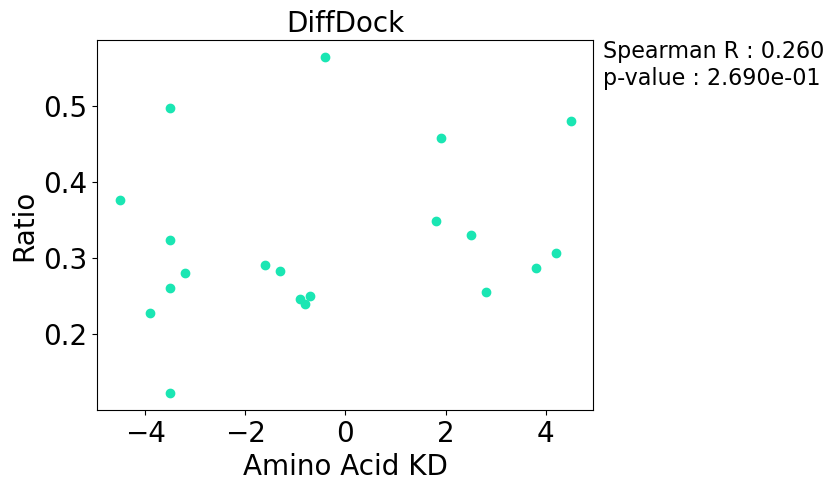

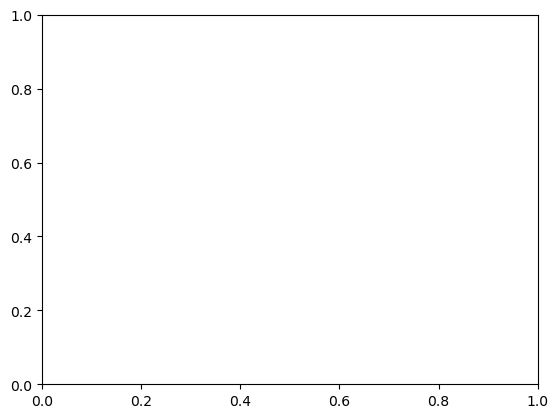

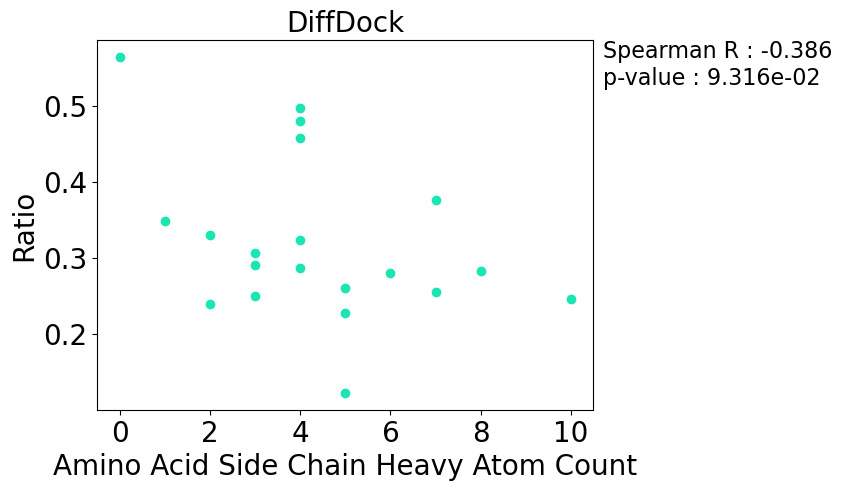

SignificanceResult(statistic=0.22026645449672183, pvalue=0.36486273693786087)


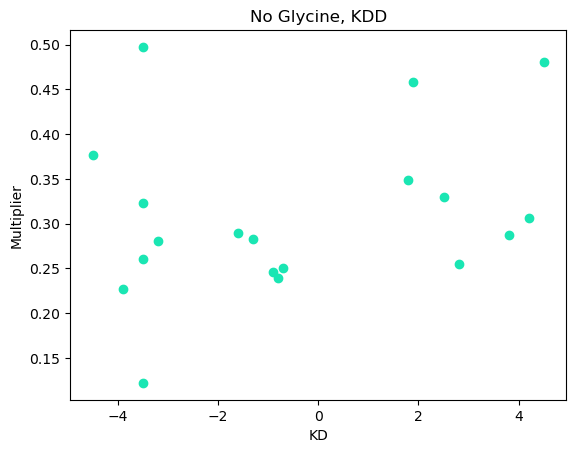

    names   top_rmsd                                      ligand_smiles  \
0    6qqw   0.989859  [H]c1c([H])c([H])c(C([H])([H])n2c([H])c([H])c3...   
1    6d08   3.306565  [H]/N=C(/N([H])[H])N([H])C([H])([H])C([H])([H]...   
2    6jap   2.759096  [H]OC([H])([H])[C@@]1(O[C@@]2([H])O[C@]([H])(C...   
3    6np2   3.348641  [H]O[C@]1([H])[C@@]([H])(O[C@@]2([H])OC([H])([...   
4    6uvp   0.894009  [H]/N=C1\SC([H])([H])[C@]2([H])C([H])([H])OC([...   
..    ...        ...                                                ...   
358  6pya   4.656605  [H]c1nc([H])n(C([H])([H])c2c(-c3c([H])c([H])c(...   
359  6ffe   1.061407  [H]OC(=O)c1c([H])c([H])c([H])c([H])c1C([H])([H...   
360  6d3x  12.816111  [H]/N=C(/N([H])[H])N([H])C([H])([H])C([H])([H]...   
361  6gj8   4.204856  [H]Oc1c([H])c([H])c2c(c1[H])[C@@]([H])(c1c(C([...   
362  6mo2  14.493142  [H]c1nc(-c2c([H])c([H])c(C([H])([H])[N+]([H])(...   

        LogP  PctHeteroatoms  CountHeteroatoms  CountAllAtoms  \
0    3.66190        0.181818      

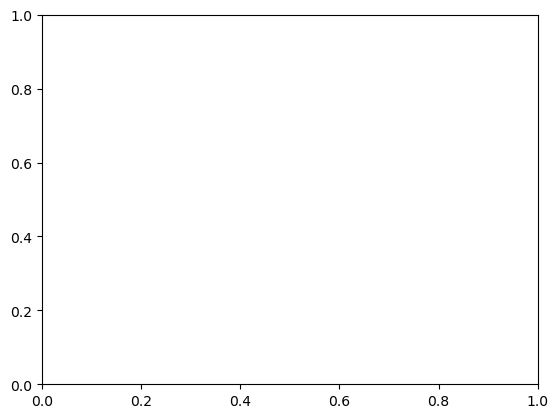

In [86]:
path_pdbbind = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"
df_pdb = create_df(complex_names, rmsds, confidences, path_pdbbind, bsite_comp.item(), w_info.item(), None, None)
print(df_pdb)

On 0
3.838174490552998
On 1
5.936729419902741
On 2
4.915177931300043
On 3
6.550807011355481
On 4
3.194062833446059
On 5
3.8441391650548686
On 6
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
3.8550289629328875
On 7
4.096027852501725
On 8
3.590704330247671
On 9
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
5.158174370539808
On 10
4.187444321191943
On 11
4.853972290316465
On 12
5.330789765280794
On 13
3.21604463464609
On 14
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
2.514071968160846
On 15
4.372582764124868
On 16
Can't kekulize mol.  Unkekulized atoms: 103 104 105 1

[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 110 111
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
[12:38:32] Explicit valence for atom # 3 C, 6, is greater than permitted
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[12:38:32] Can't kekulize m

4.561331014834549
On 77
3.7055934227476492
On 78
5.884296491053685
On 79
4.438670973315251
On 80
2.3004418451632858
On 81
4.298703958713916
On 82
4.916048115051465
On 83
1.7878885848747492
On 84
5.824082506170177
On 85
3.80554855452064
On 86
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
5.736530409010855
On 87
2.5687565190073287
On 88
5.0417350724712735
On 89
3.1455980833568513
On 90
3.8949547750381877
On 91
5.722992559254424
On 92
4.47355142765344
On 93
7.87369754284811
On 94
4.88299543376757
On 95
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
3.9351662038543602
On 96
3.213648201615511
On 97
3.5930226487866794
On 98
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
RDKit was unable to read the molecule.


[12:38:32] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
[12:38:32] Explicit valence for atom # 0 C greater than permitted
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[12:38:32] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
[12:38:32] Can't kekulize mol. 

2.82896710879732
On 161
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
5.205422742691677
On 162
3.251893461297156
On 163
7.666951809108611
On 164
3.7898573437088863
On 165
4.5791252738654356
On 166
Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
5.747819850042325
On 167
4.791889140136983
On 168
2.238110973053631
On 169
3.536072561781436
On 170
1.8510268576601023
On 171
9.22910176660557
On 172
6.7004188518324765
On 173
3.1257636799478723
On 174
Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
3.9306071564480134
On 175
5.087694673484949
On 176
2.5960822574747024
On 177
8.451543368555559

[12:38:32] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12


3.1084593621446888
On 242
4.152571724102712
On 243
4.689737129580394
On 244
3.365066474148129
On 245
4.029524536804633
On 246
4.07615177903016
On 247
4.960487377031629
On 248
3.5107553266518514
On 249
3.3106062139066554
On 250
2.219784021399363
On 251
5.978091947572741
On 252
3.5083532057175115
On 253
5.668736738141466
On 254
4.752962406692846
On 255
2.7503504065001967
On 256
4.782338515257007
On 257
2.9161722890106665
On 258
5.287529069676214
On 259
4.764696941030398
On 260
3.0651586062404923
On 261
6.1968303111311025
On 262
5.036290653431258
On 263
4.96828456011716
On 264
4.043439014759641
On 265
6.11840538356028
On 266
4.431958689450974
On 267
5.1182641435438265
On 268
7.359589388985964
On 269
5.0113644231266585
On 270
3.562356742485619
On 271
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
3.378126171903267
On 272
3.9987234591307748
On 273
5.1158933054

[12:38:32] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[12:38:32] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16


6.48717371743814
On 318
4.948027948095842
On 319
5.335728062100872
On 320
5.092476487211673
On 321
8.321344287532266
On 322
4.403026151941272
On 323
2.9776937430518498
On 324
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
4.670710497614341
On 325
5.022131162490809
On 326
3.967128450265712
On 327
5.053792257878841
On 328
Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
3.336987369661666
On 329
3.8883462996965905
On 330
7.687233794103643
On 331
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
2.107076537286937
On 332
2.624702129586394
On 333
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 

[12:38:33] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[12:38:33] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22


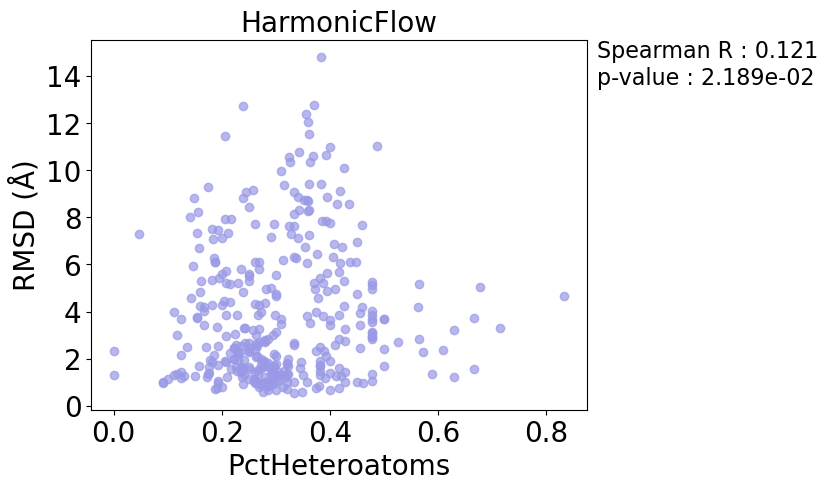

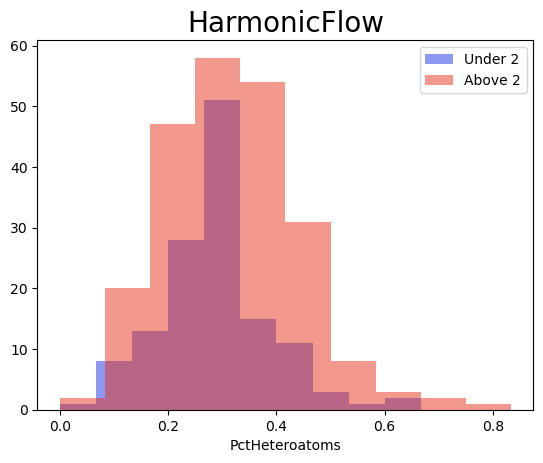

PearsonRResult(statistic=0.09889498706361005, pvalue=0.0612275430152045)
SignificanceResult(statistic=0.12096119404852106, pvalue=0.021887320243918453)
TtestResult(statistic=-2.6102018798325175, pvalue=0.009429968518702104, df=357.0)


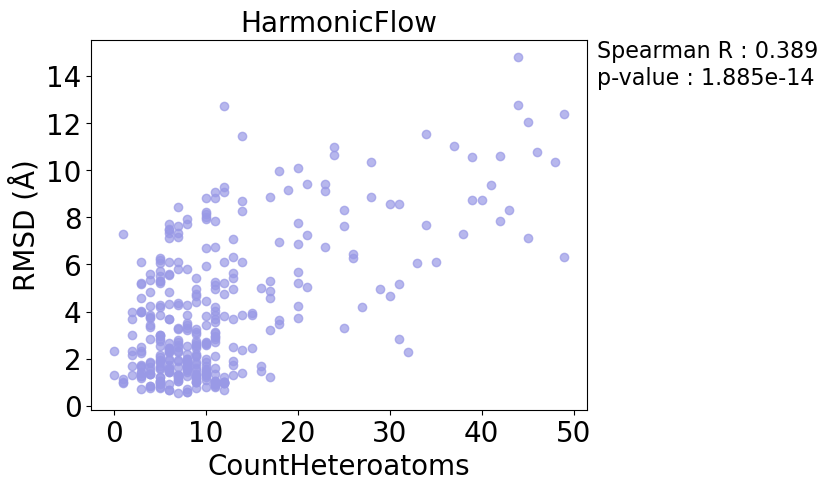

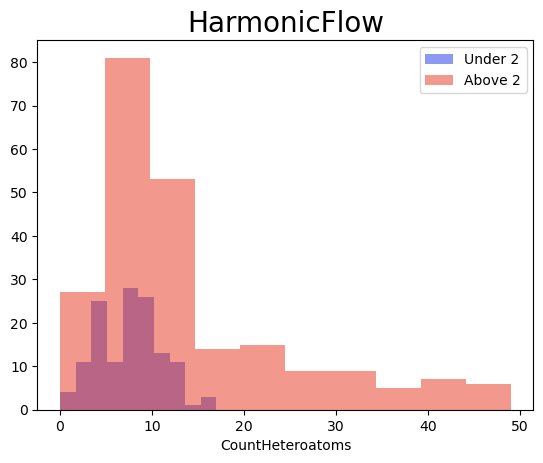

PearsonRResult(statistic=0.6076434024603338, pvalue=1.3077570639369174e-37)
SignificanceResult(statistic=0.38947226986945827, pvalue=1.8854752431148573e-14)
TtestResult(statistic=-6.054963614692632, pvalue=3.558730706648139e-09, df=357.0)


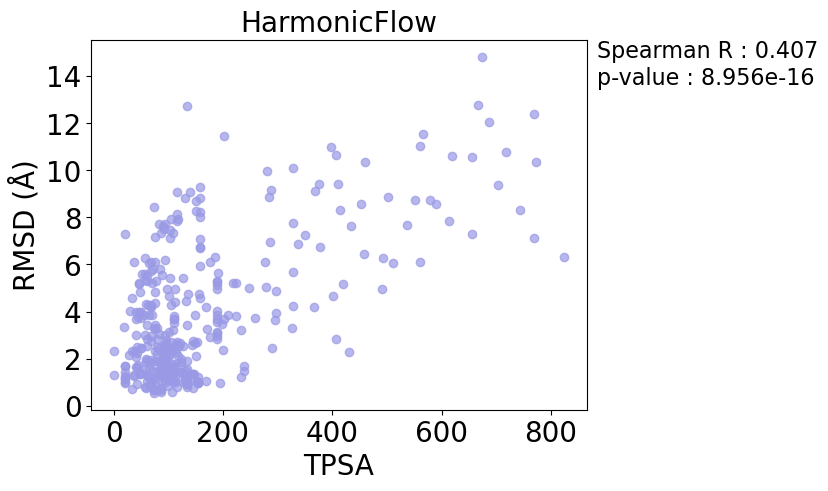

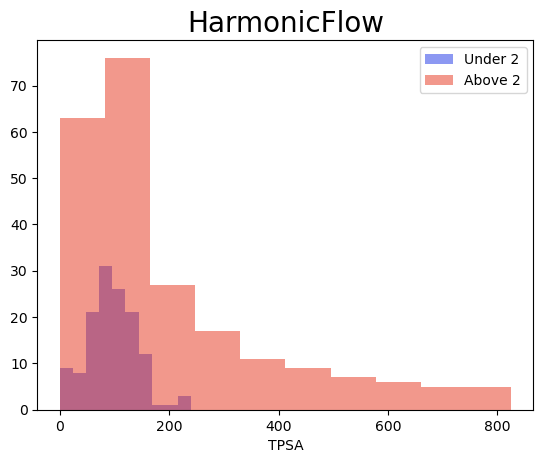

PearsonRResult(statistic=0.6244606670408185, pvalue=3.2772596962265086e-40)
SignificanceResult(statistic=0.40724096006275123, pvalue=8.955542647123665e-16)
TtestResult(statistic=-6.531598988528347, pvalue=2.2422140440587202e-10, df=357.0)


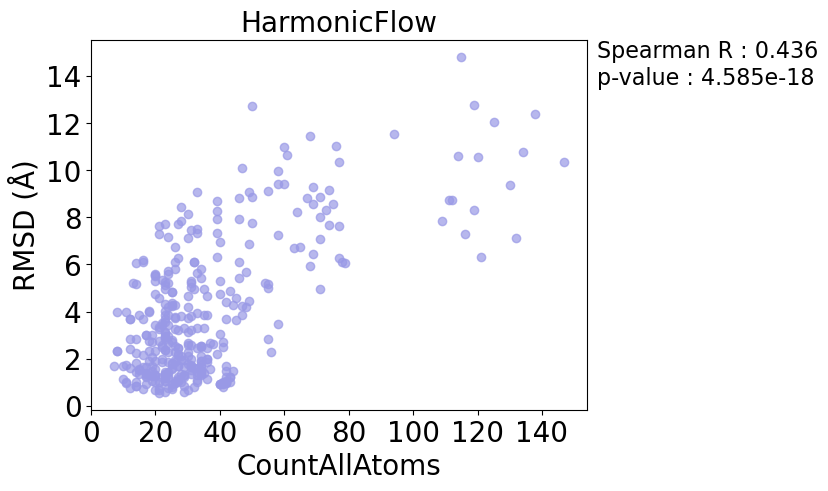

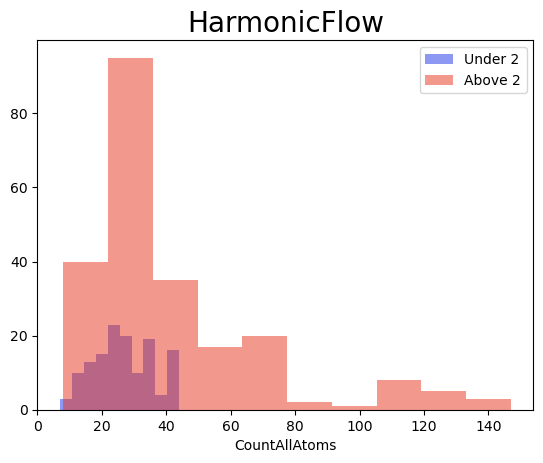

PearsonRResult(statistic=0.6617737277482925, pvalue=1.3760855223202497e-46)
SignificanceResult(statistic=0.43570239597499244, pvalue=4.584669923954353e-18)
TtestResult(statistic=-5.784350975618147, pvalue=1.5917761419657147e-08, df=357.0)


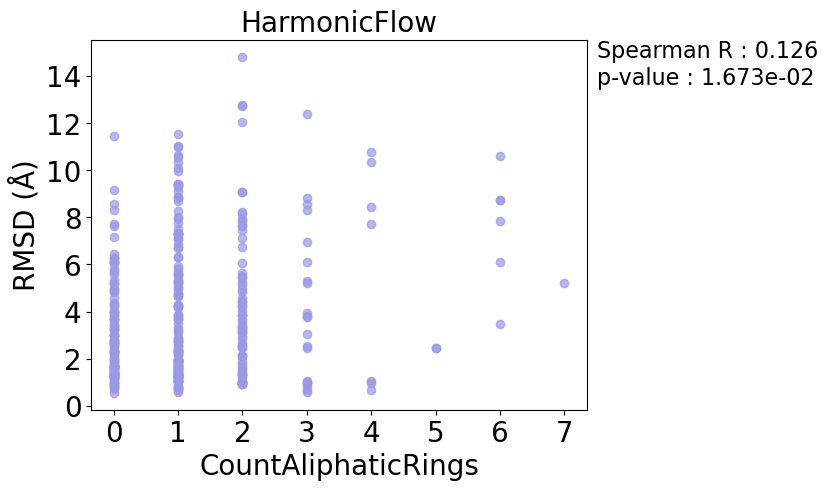

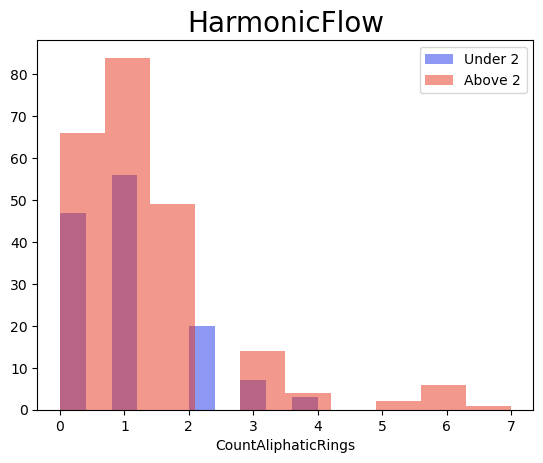

PearsonRResult(statistic=0.20456586822729672, pvalue=9.468893408799636e-05)
SignificanceResult(statistic=0.12621598934538034, pvalue=0.0167254786332144)
TtestResult(statistic=-2.4591492637264576, pvalue=0.01440038167150879, df=357.0)


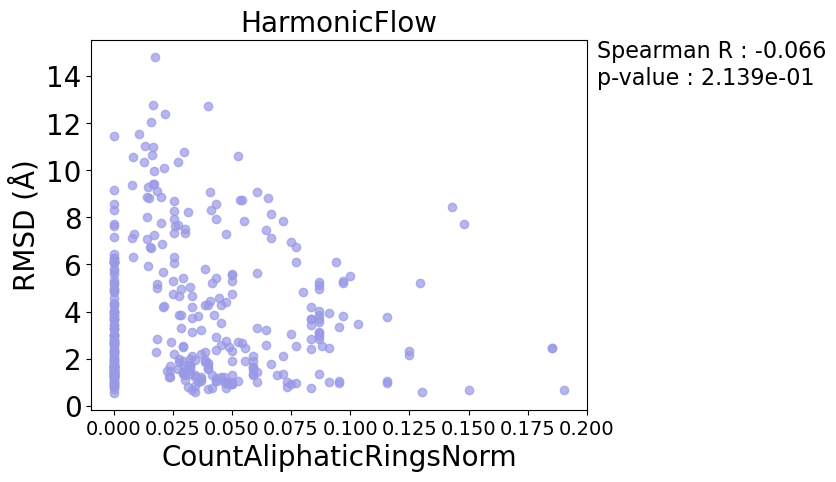

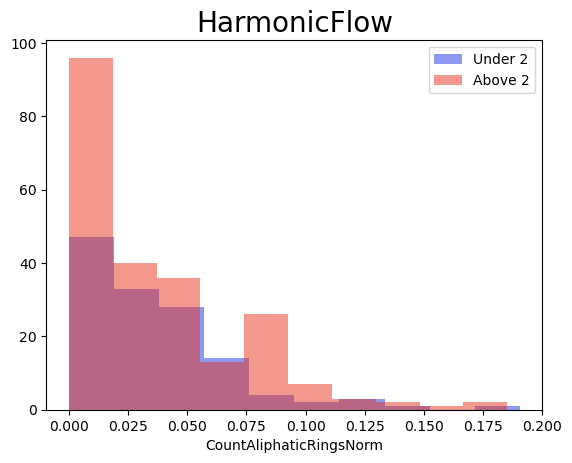

PearsonRResult(statistic=-0.0858624079266847, pvalue=0.10433581285210516)
SignificanceResult(statistic=-0.06575874677808766, pvalue=0.2138859390123296)
TtestResult(statistic=-0.5648207368623747, pvalue=0.5725504318357215, df=357.0)


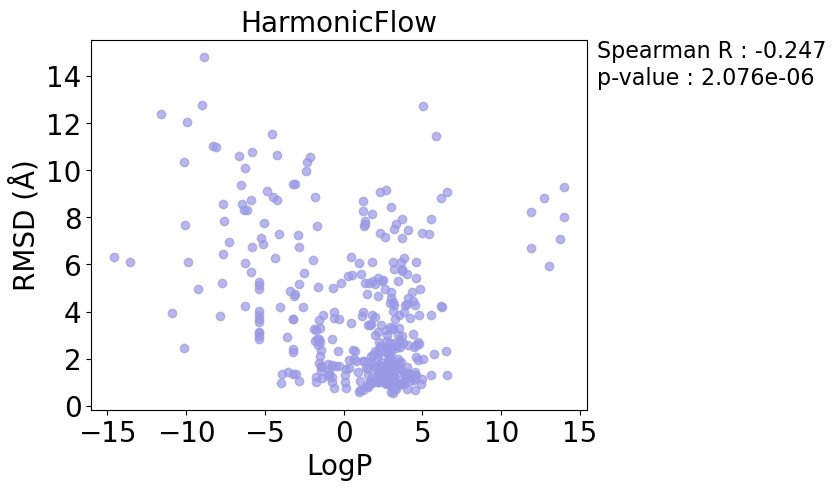

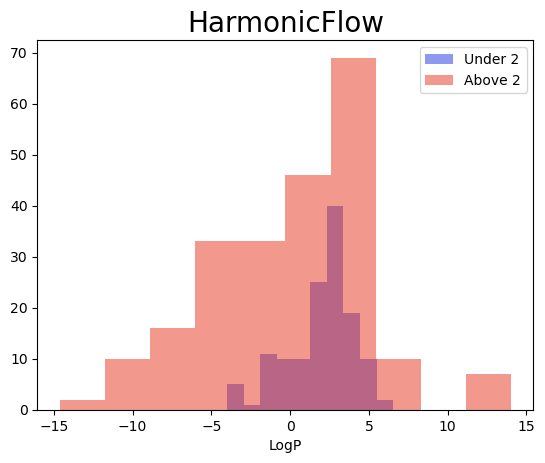

PearsonRResult(statistic=-0.31583915859149714, pvalue=9.310450045466966e-10)
SignificanceResult(statistic=-0.2474349920056311, pvalue=2.076090639774314e-06)
TtestResult(statistic=4.190036255320563, pvalue=3.519309186114761e-05, df=357.0)


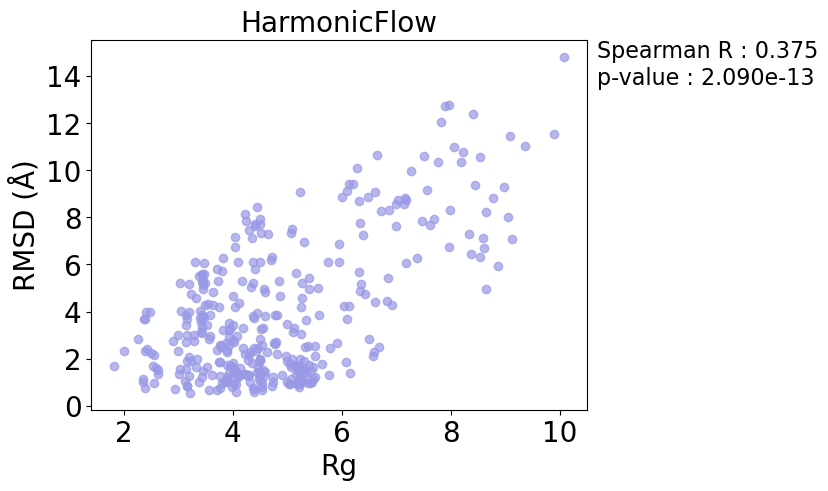

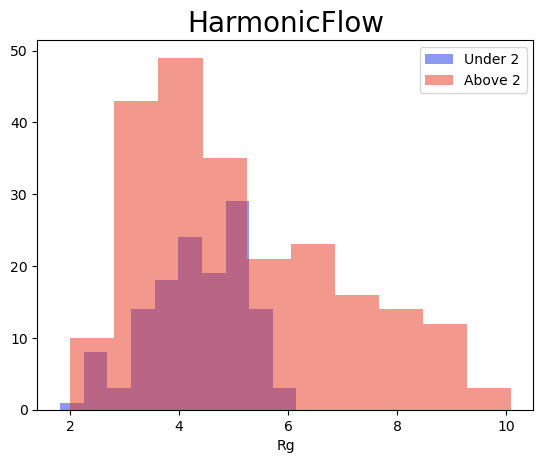

PearsonRResult(statistic=0.6179340215432321, pvalue=3.496434602434886e-39)
SignificanceResult(statistic=0.3746463640466223, pvalue=2.0897138136744645e-13)
TtestResult(statistic=-4.754707027060936, pvalue=2.8877052498707344e-06, df=357.0)


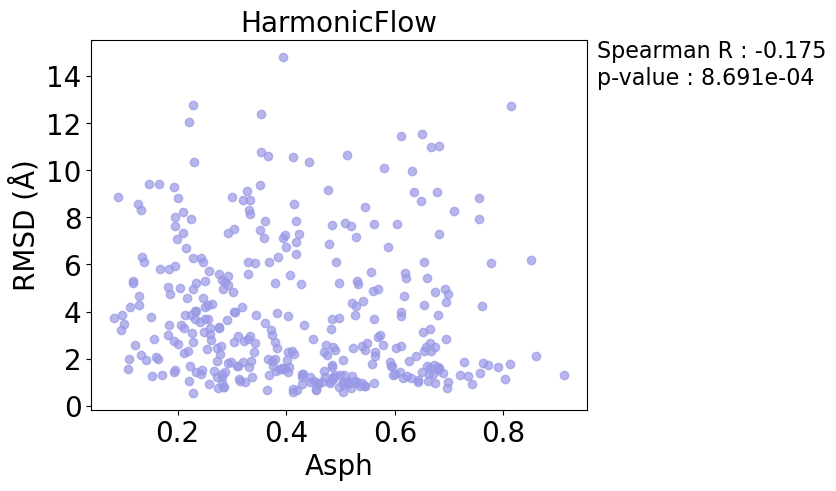

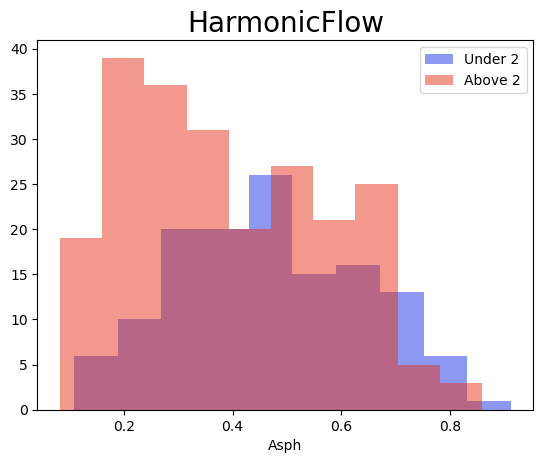

PearsonRResult(statistic=-0.10334434561737282, pvalue=0.0504052824886511)
SignificanceResult(statistic=-0.17499183019249626, pvalue=0.0008691228845889509)
TtestResult(statistic=3.863036923248252, pvalue=0.00013297170167184596, df=357.0)


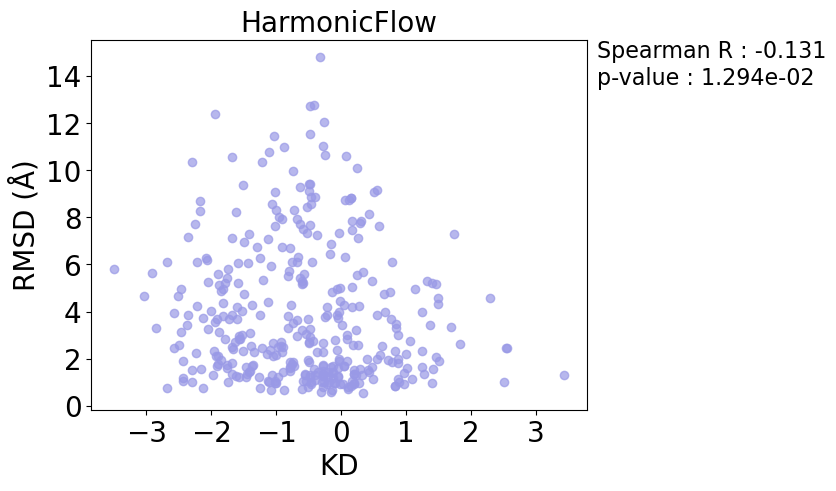

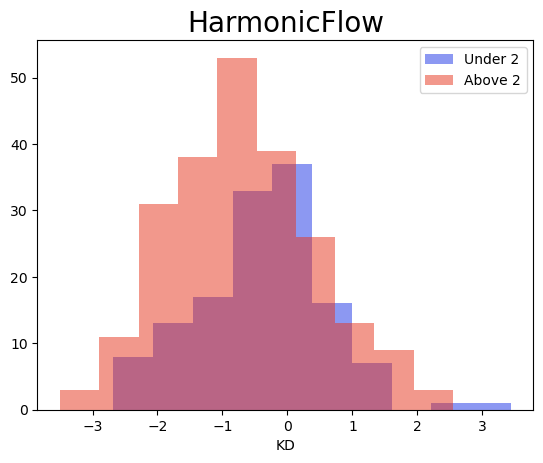

PearsonRResult(statistic=-0.10263156720866741, pvalue=0.052023135835230785)
SignificanceResult(statistic=-0.13106514755485246, pvalue=0.012940610208016146)
TtestResult(statistic=2.6582664279478014, pvalue=0.008207737966203311, df=357.0)


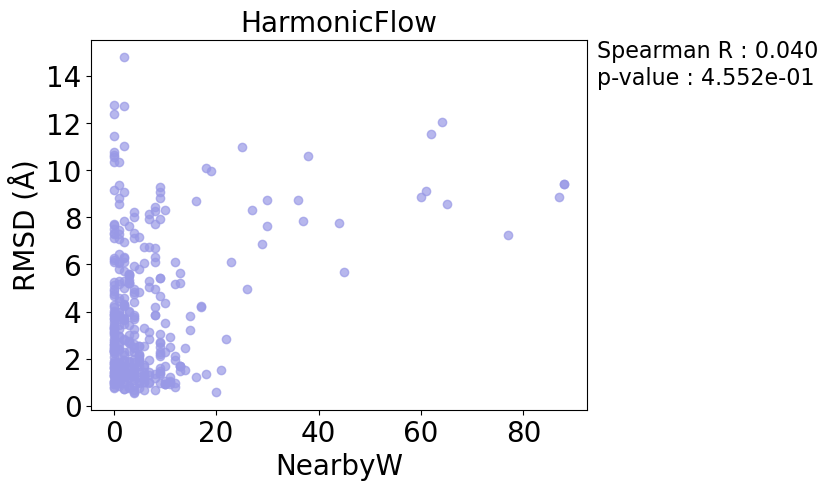

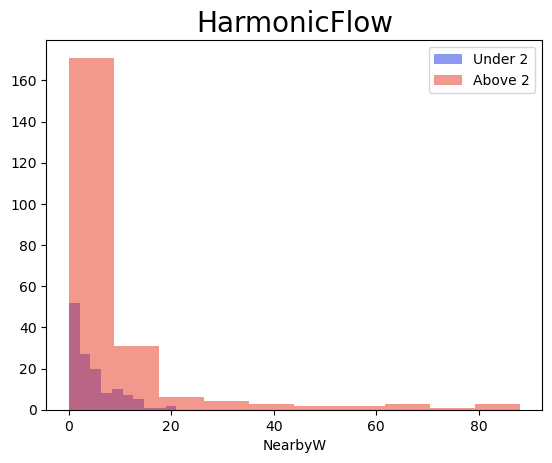

PearsonRResult(statistic=0.33761270074387767, pvalue=5.086317411078195e-11)
SignificanceResult(statistic=0.03953738566641996, pvalue=0.45518066877388785)
TtestResult(statistic=-2.5128605990254234, pvalue=0.01241563706276202, df=357.0)


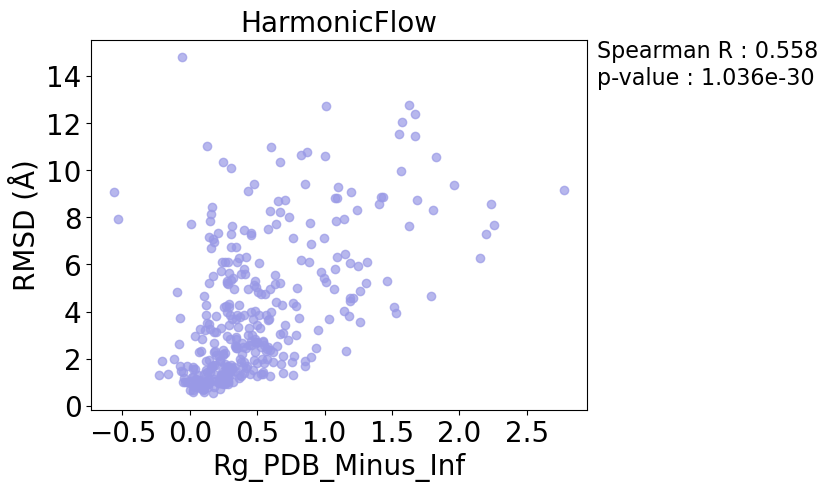

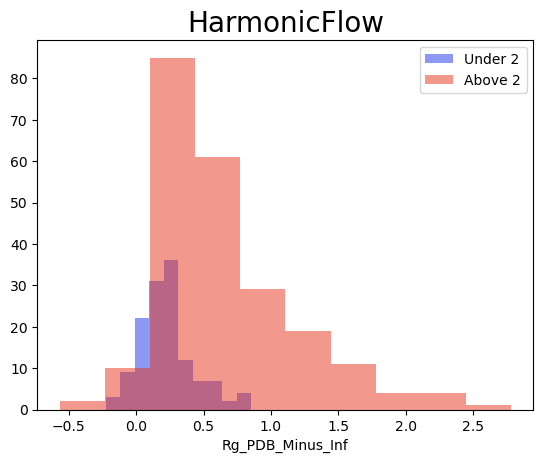

PearsonRResult(statistic=0.5324114085756472, pvalue=1.1383091461747837e-27)
SignificanceResult(statistic=0.5575400839285622, pvalue=1.0358184597485413e-30)
TtestResult(statistic=-8.859681757390586, pvalue=3.8459282133764274e-17, df=357.0)


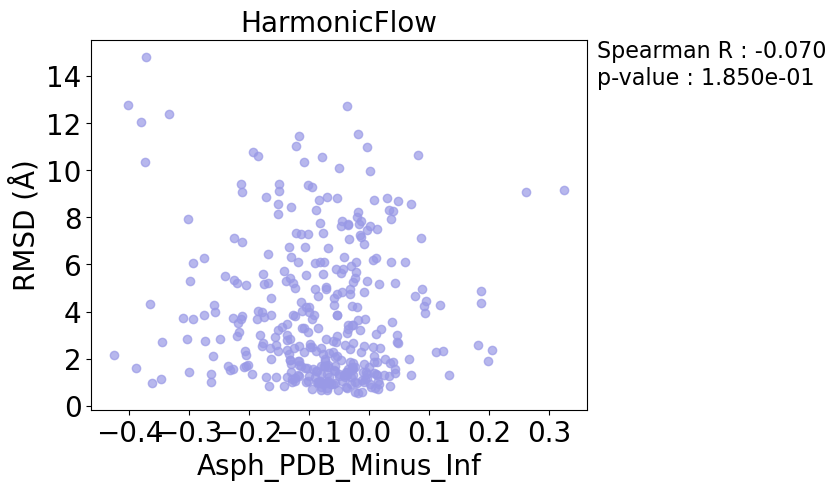

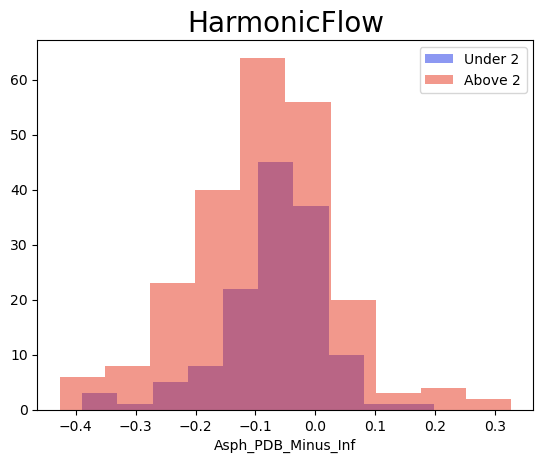

PearsonRResult(statistic=-0.07607924825651464, pvalue=0.15027681248691085)
SignificanceResult(statistic=-0.0701138067153224, pvalue=0.18501674090649037)
TtestResult(statistic=1.51883444755937, pvalue=0.12968924745437965, df=357.0)
Power_divergenceResult(statistic=112.55052626554561, pvalue=2.695402079144104e-15)
Power_divergenceResult(statistic=129.63961992609646, pvalue=1.7058701968929378e-18)
KstestResult(statistic=0.8, pvalue=1.3259673752008224e-06, statistic_location=147, statistic_sign=1)
AA Under 2 freq Over 2 freq Multiplier
ALA 122 257  0.47
ARG 81 257  0.32
ASN 70 240  0.29
ASP 190 400  0.47
CYS 26 107  0.24
GLN 35 213  0.16
GLU 93 309  0.30
GLY 248 376  0.66
HIS 64 195  0.33
ILE 111 228  0.49
LEU 147 353  0.42
LYS 65 213  0.31
MET 60 93  0.65
PHE 81 269  0.30
PRO 83 166  0.50
SER 84 321  0.26
THR 103 264  0.39
TRP 34 207  0.16
TYR 127 316  0.40
VAL 107 315  0.34
SignificanceResult(statistic=0.3056625536749152, pvalue=0.19000036817000704)


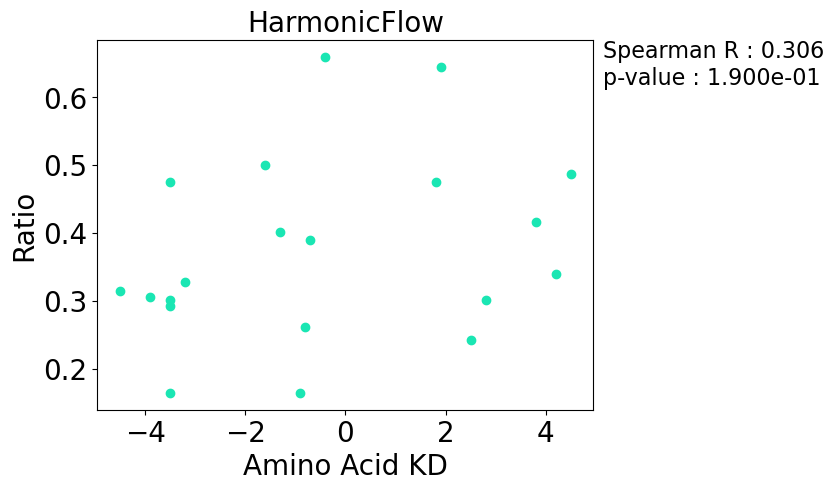

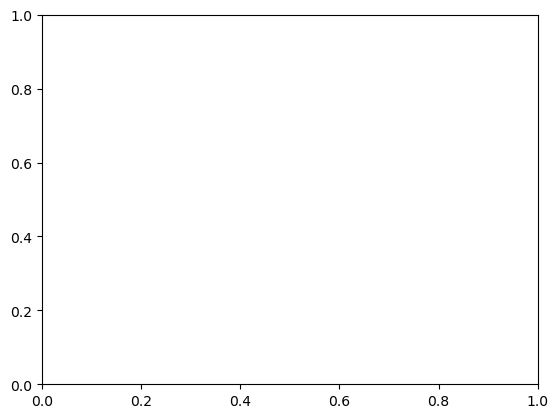

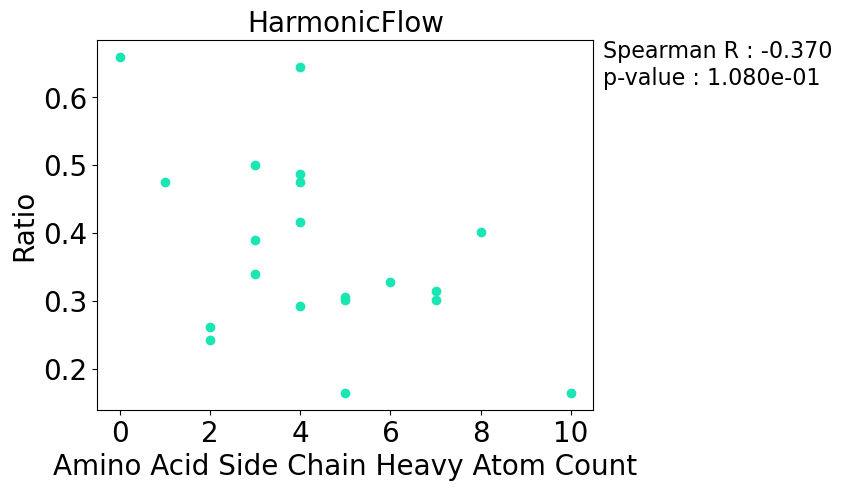

SignificanceResult(statistic=0.2845842592097646, pvalue=0.23765261912937433)


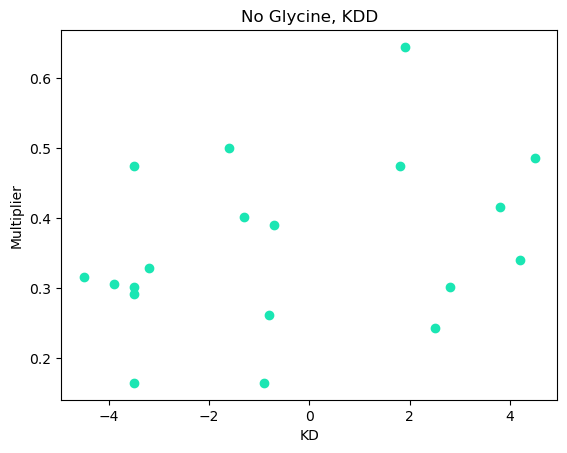

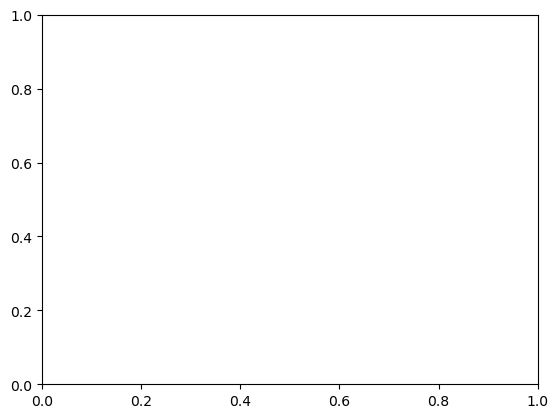

In [102]:
df_pdb_hf = create_df(None, None, None, path_pdbbind, bsite_comp_hf.item(), w_info_hf.item(), hf_rmsd_dict,
                     "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt")

In [95]:
df_pdb_hf

,names,top_rmsd,ligand_smiles,LogP,PctHeteroatoms,CountHeteroatoms,CountAllAtoms,CountAliphaticRings,CountAliphaticRingsNorm,TPSA,Rg,Asph,KD,Residues,NearbyW
0,None,2.198797,[H]c1c([H])c(C([H])([H])[H])c(S(=O)(=O)N([H])C...,2.81544,0.296296,8.0,27,1,0.037037,101.30,4.228035,0.414297,1.000000,"[LEU, MET, ASN, TRP, PRO, PHE, ILE]",5
1,None,7.256658,[H]/N=C(/N([H])[H])N([H])C([H])([H])C([H])([H]...,-2.88533,0.362069,21.0,58,1,0.017241,350.18,6.387752,0.398489,-0.375325,"[THR, TYR, SER, LEU, VAL, ILE, GLU, ILE, HIS, ...",77
2,None,3.114401,[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(Sc2c([H]...,2.16502,0.300000,9.0,30,1,0.033333,100.63,5.096143,0.651723,-2.455556,"[ALA, GLU, HIS, ASN, ARG, GLY, SER, ASN, ARG]",7
3,None,7.925958,[H]C1=NC(=O)c2c(nc(-c3c([H])c([H])c(C([H])([H]...,5.55360,0.217391,10.0,46,2,0.043478,116.99,7.691995,0.755478,-0.914286,"[TRP, ASP, ILE, ASP, GLU, GLU, CYS, CYS, LYS, ...",9
4,None,1.637575,[H]c1sc(N([H])C(=O)C([H])([H])C([H])([H])[H])n...,3.15860,0.250000,4.0,16,0,0.000000,41.99,3.521512,0.680138,1.250000,"[CYS, GLY, ARG, TYR, LEU, VAL, LEU, MET]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,None,2.127826,[H]c1nc(N2C([H])([H])C([H])([H])N(C(=O)c3c([H]...,1.72430,0.264706,9.0,34,2,0.058824,118.72,5.509876,0.563672,-1.044444,"[ASN, SER, TYR, GLY, TYR, HIS, GLY, TYR, PHE]",9
355,None,2.949758,[H]c1c([H])c(C([H])([H])n2c([H])c([H])c3c([H])...,3.67050,0.208333,5.0,24,0,0.000000,68.86,4.086136,0.310743,-0.670588,"[SER, ILE, GLY, TYR, VAL, LEU, ASN, GLY, GLY, ...",1
356,None,2.574102,[H]OC(=O)[C@@]1([H])C([H])([H])[C@]1([H])C(=O)...,4.08990,0.225806,7.0,31,2,0.064516,92.62,4.538931,0.473214,0.266667,"[TYR, LEU, VAL, ARG, ALA, LEU, ALA, LEU, TRP, ...",0
357,None,3.440050,[H]c1c([H])c([H])c2c(c1[H])C(=O)N([H])[C@]2([H...,2.39900,0.166667,4.0,24,2,0.083333,61.50,3.526295,0.206748,0.012500,"[TYR, GLU, LEU, SER, VAL, THR, ASP, MET]",1


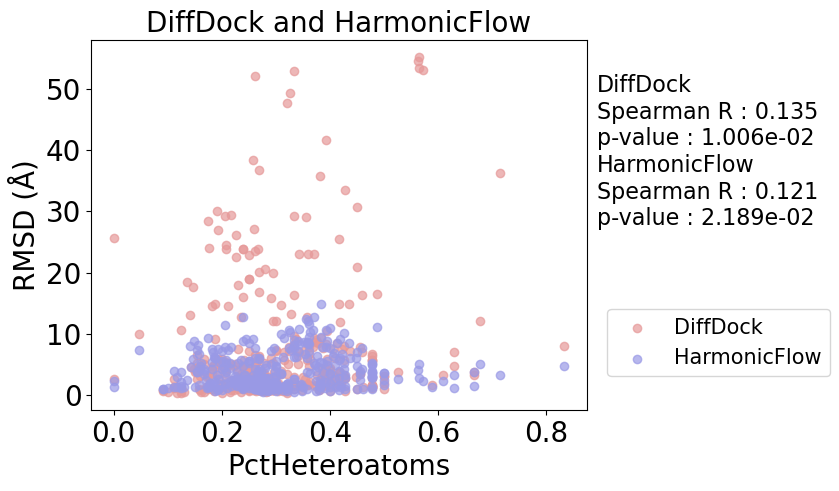

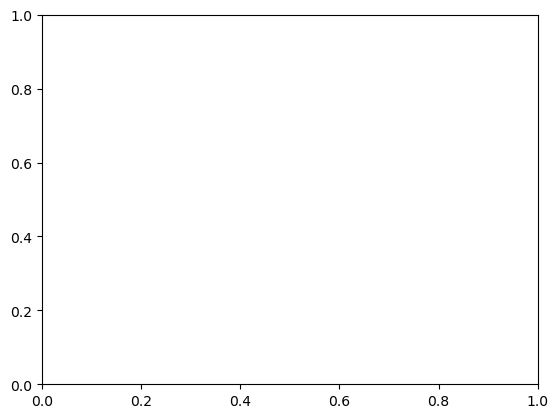

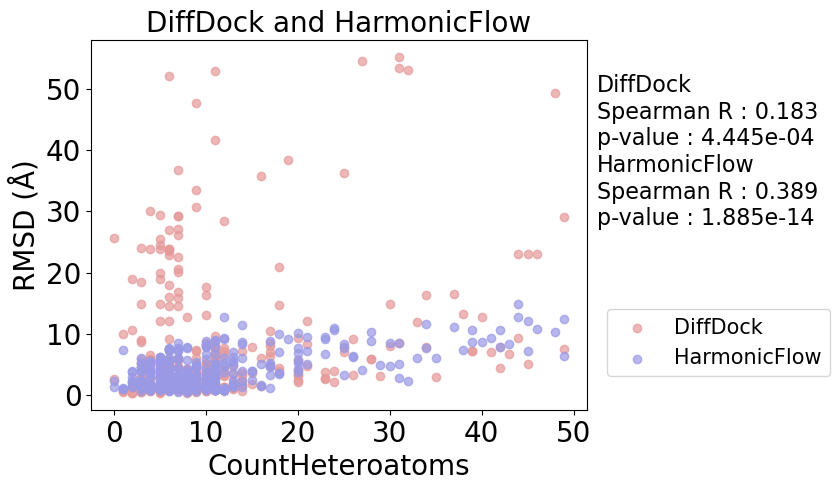

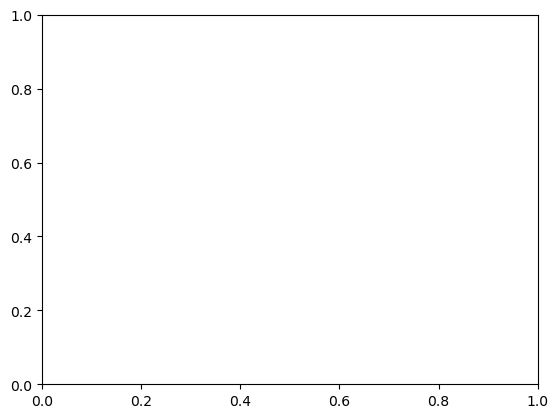

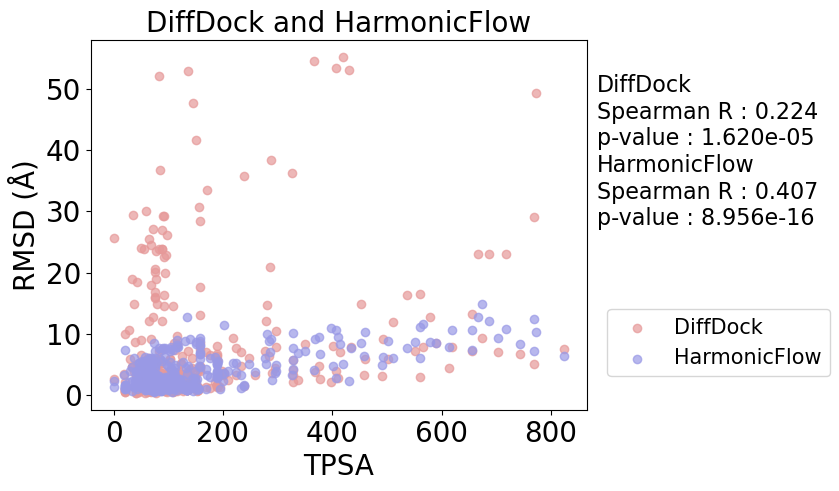

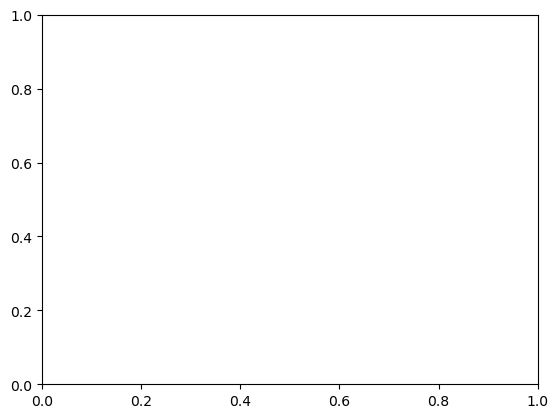

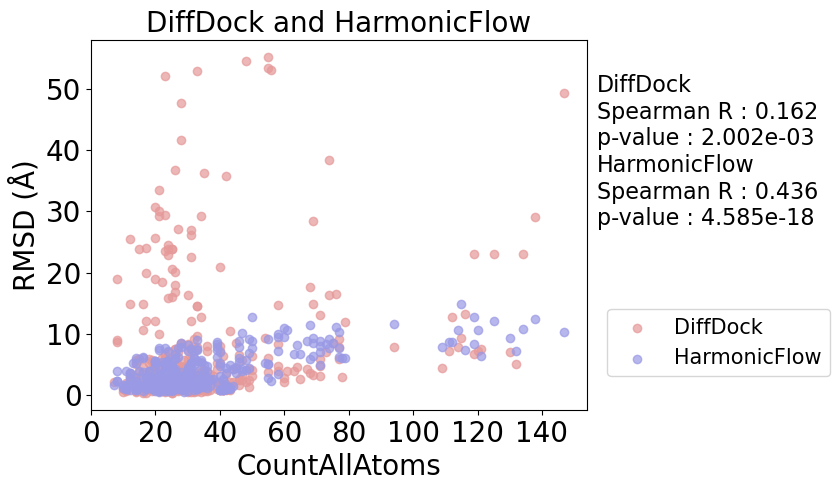

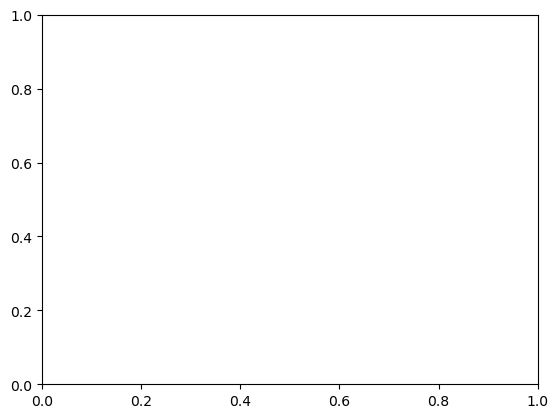

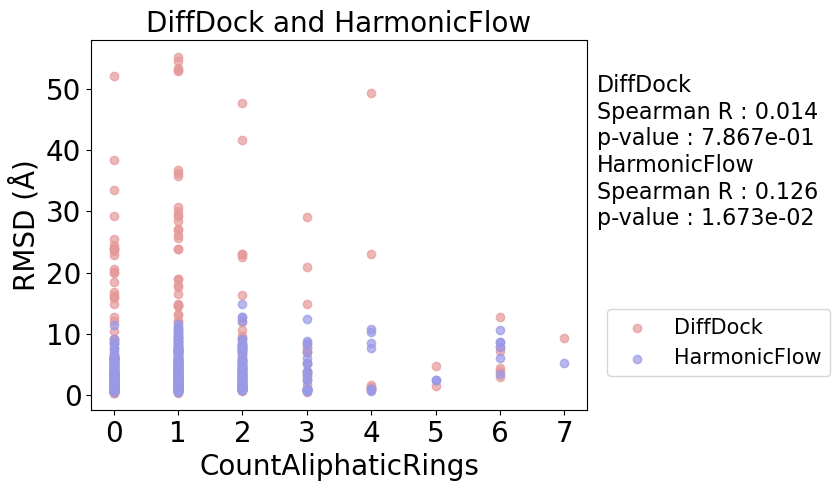

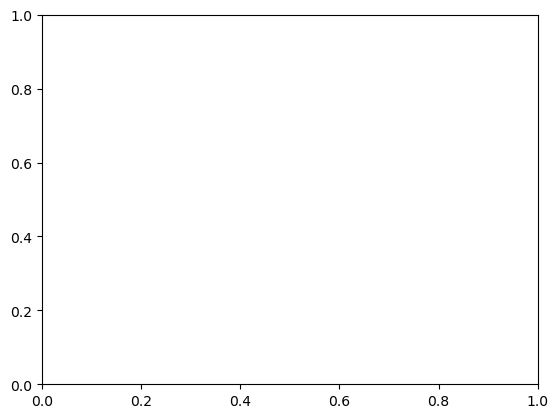

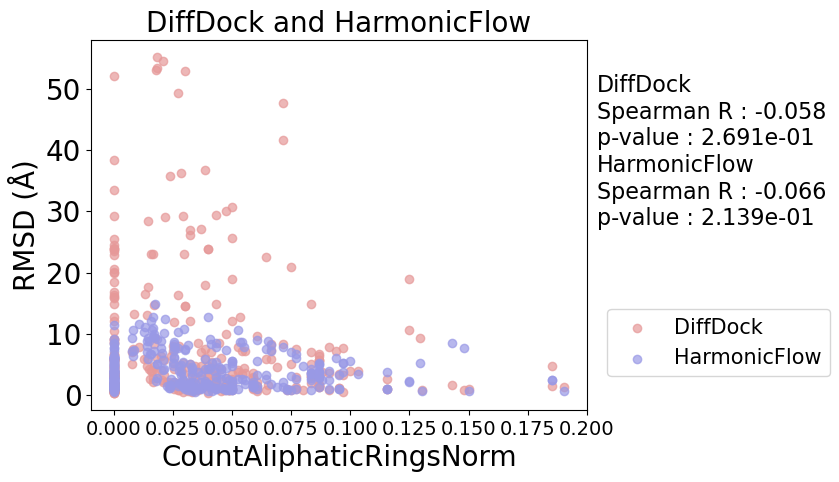

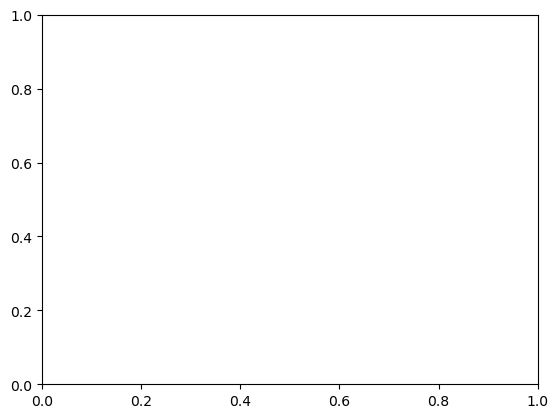

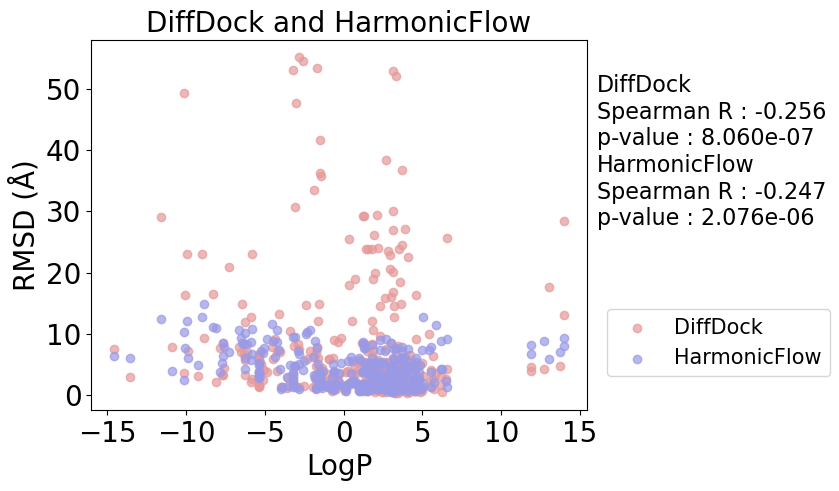

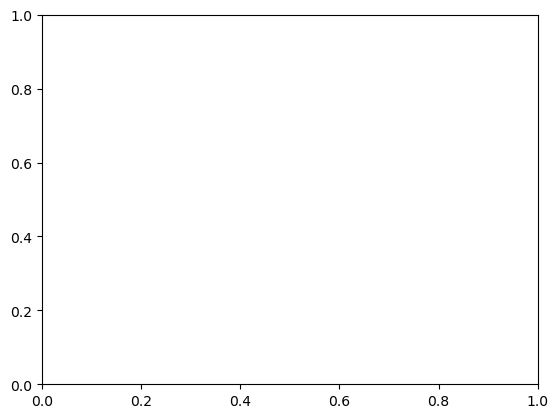

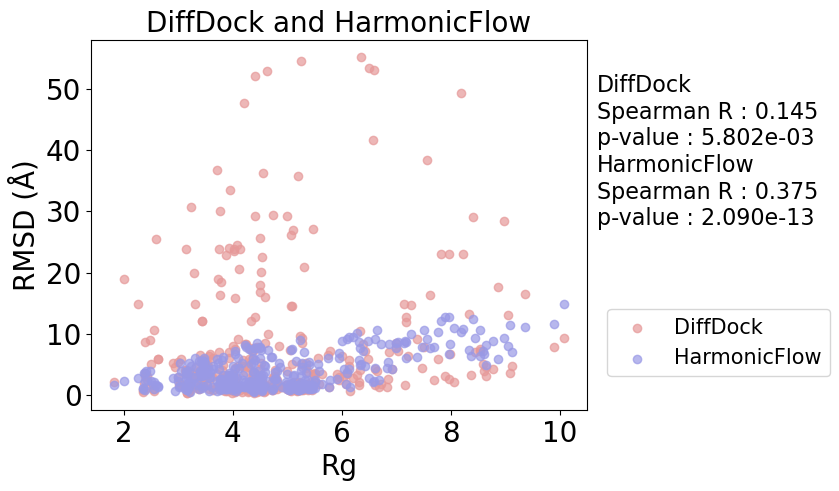

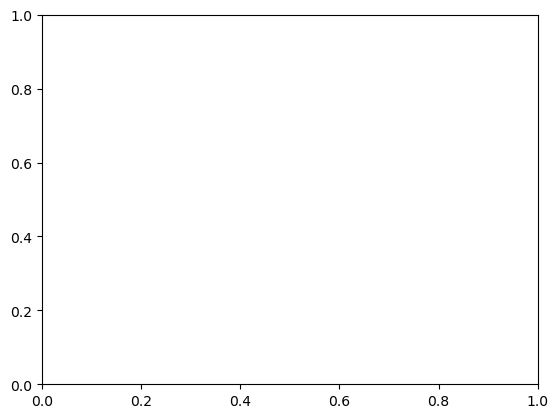

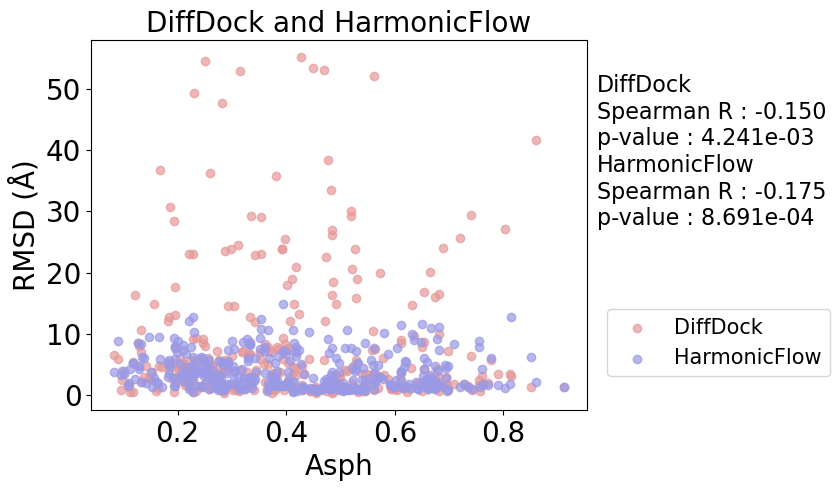

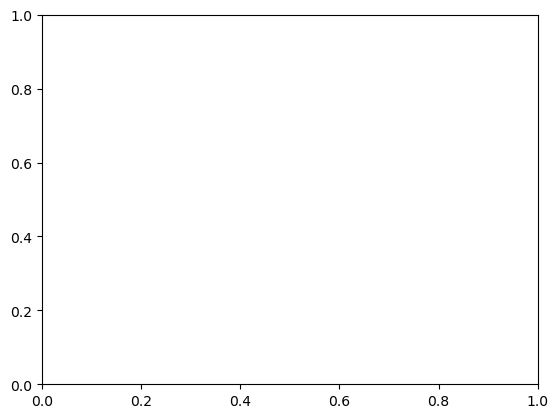

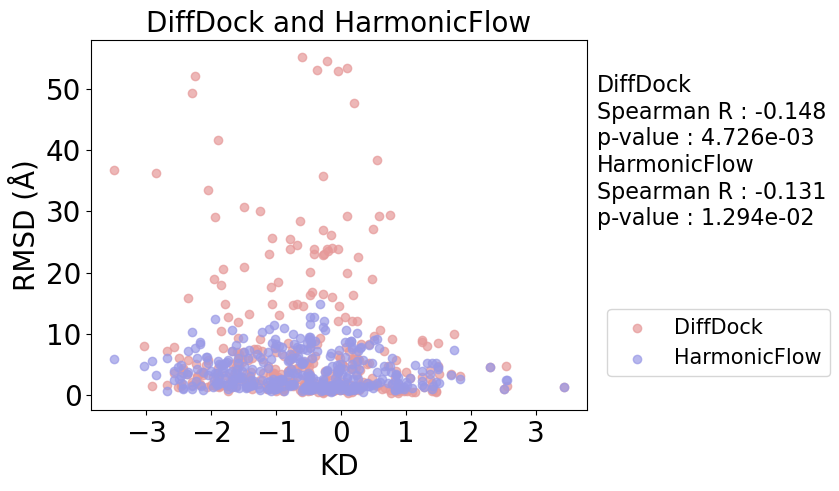

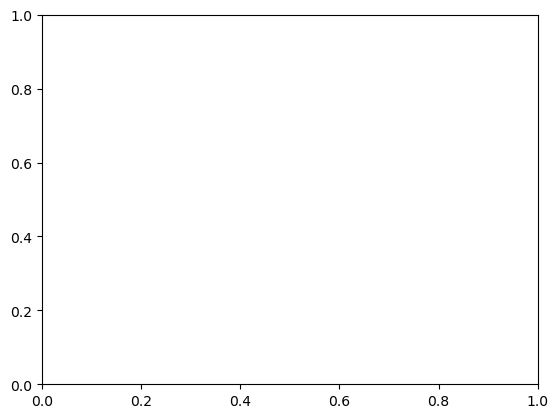

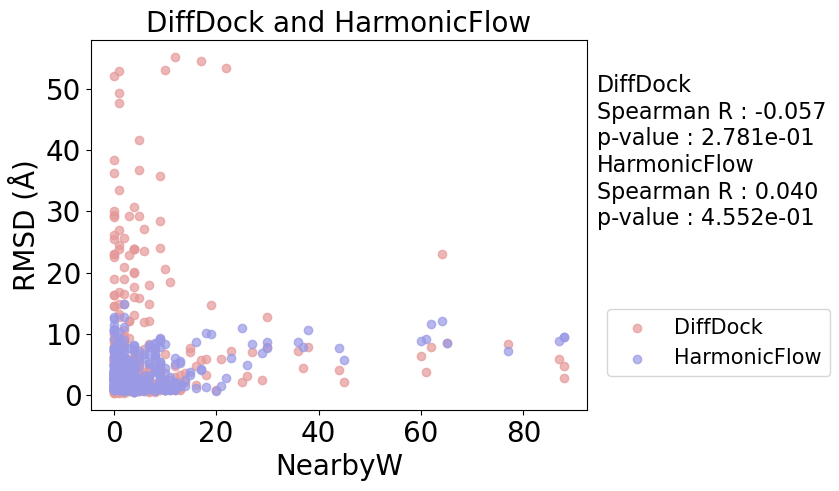

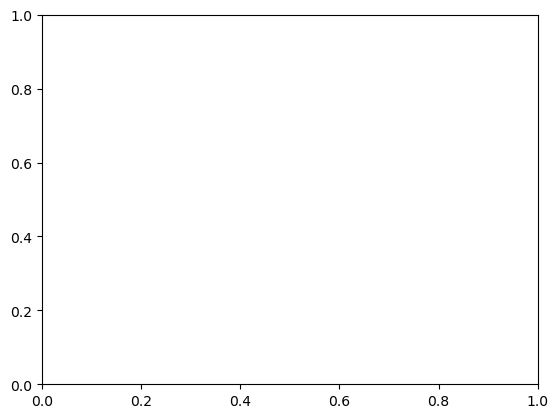

In [72]:
plot_multiple_methods(df_pdb, df_pdb_hf, "DiffDock", "HarmonicFlow", "CountAllAtoms")

#### Scatterplot, histogram, R2 calc for each metric
pltlist = ["PctHeteroatoms", "CountHeteroatoms", "TPSA", "CountAllAtoms", "CountAliphaticRings", "CountAliphaticRingsNorm", "LogP", "Rg", "Asph", "KD", "NearbyW"]

#iterate over metrics
for p in pltlist:
    fp, ap = plt.subplots()
    plt.scatter(df_pdb[p], df_pdb["top_rmsd"], alpha = 0.7, color = [0.1, 0.9, 0.7])
    plt.xlabel(p, fontsize = 20)
    plt.ylabel("RMSD (Å)", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    spearman_r = scipy.stats.spearmanr(df_pdb[p], df_pdb["top_rmsd"])
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    plt.text(1.02, 0.88, f"Spearman R : {spearman_r[0]:.3f}\np-value : {spearman_r[1]:.3e}", transform=ap.transAxes, fontsize = 16)
    plt.show()
    plt.close()
    
    #split histogram. by rmsd
    less_than_2 = df_pdb[df_pdb["top_rmsd"] < 2][p]
    greater_than_2 = df_pdb[df_pdb["top_rmsd"] >= 2][p]
    plt.hist(less_than_2, color = [0.1, 0.2, 0.9], label = "Under 2", alpha = 0.5)
    plt.hist(greater_than_2, color = [0.9, 0.2, 0.1], label = "Above 2", alpha = 0.5)
    plt.xlabel(p)
    plt.legend()
    plt.show()
    plt.close()

    print(scipy.stats.pearsonr(df_pdb[p], df_pdb["top_rmsd"]))
    #spearman thank you Jeremy for the suggestion!
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    print(scipy.stats.spearmanr(df_pdb[p], df_pdb["top_rmsd"]))
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    #TODO- is this the correct test?
    print(scipy.stats.ttest_ind(less_than_2, greater_than_2))

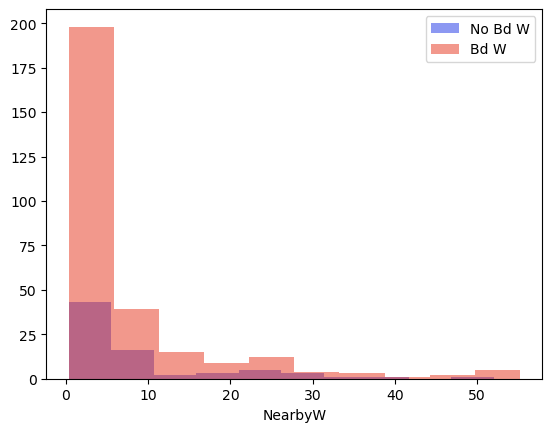

TtestResult(statistic=0.9699270458861218, pvalue=0.3327322477740645, df=361.0)


In [131]:
#split histogram. by rmsd
less_than_2 = df_pdb[df_pdb["NearbyW"] < 1]["top_rmsd"]
greater_than_2 = df_pdb[df_pdb["NearbyW"] >= 1]["top_rmsd"]
plt.hist(less_than_2, color = [0.1, 0.2, 0.9], label = "No Bd W", alpha = 0.5)
plt.hist(greater_than_2, color = [0.9, 0.2, 0.1], label = "Bd W", alpha = 0.5)
plt.xlabel(p)
plt.legend()
plt.show()
plt.close()
print(scipy.stats.ttest_ind(less_than_2, greater_than_2))

In [107]:
#Chi square test
binding_site_dictionary = {"under_2" : {},
                           "over_2" : {}}

list_aas = ["ALA", 
               "CYS", 
               "ASP", 
               "GLU",
               "PHE", 
               "GLY", 
               "HIS", 
               "ILE", 
               "LYS", 
               "LEU", 
               "MET", 
               "ASN", 
               "PRO", 
               "GLN", 
               "ARG", 
               "SER",
               "THR",
               "VAL",
               "TRP",
               "TYR"]
#Names from Ref https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html
for rmsdk in binding_site_dictionary.keys():
    for aa in list_aas:
        binding_site_dictionary[rmsdk][aa] = 0

#Iterate over data frame
for df_entry in range(0, len(df_pdb)): #range(0, len(df_pdb)):
    #print(f"entry {df_entry}")
    #print(f"rmsd {df_pdb['names'][df_entry]}")
    #print(f"rmsd {df_pdb['top_rmsd'][df_entry]}")
    #print(f"residues {df_pdb['Residues'][df_entry]}")
    
    if df_pdb["top_rmsd"][df_entry] >= 2.0:
        key_use = "over_2"
    else:
        key_use = "under_2"
    
    for aa_add in df_pdb["Residues"][df_entry]:
        if aa_add != "MSE": #maybe add back in?
            binding_site_dictionary[key_use][aa_add] += 1
    #print(binding_site_dictionary)

Power_divergenceResult(statistic=112.97441604991707, pvalue=2.2499731928215436e-15)
Power_divergenceResult(statistic=119.12413694788145, pvalue=1.6168522399590598e-16)
KstestResult(statistic=0.8, pvalue=1.3259673752008224e-06, statistic_location=112, statistic_sign=1)
AA Under 2 freq Over 2 freq Multiplier
ALA 98 281  0.35
ARG 93 247  0.38
ASN 76 235  0.32
ASP 197 396  0.50
CYS 33 100  0.33
GLN 27 221  0.12
GLU 83 319  0.26
GLY 226 400  0.56
HIS 57 203  0.28
ILE 111 231  0.48
LEU 112 390  0.29
LYS 52 229  0.23
MET 49 107  0.46
PHE 73 286  0.26
PRO 56 193  0.29
SER 79 330  0.24
THR 74 296  0.25
TRP 48 195  0.25
TYR 99 350  0.28
VAL 100 326  0.31
SignificanceResult(statistic=0.25962449003498966, pvalue=0.2689837363861518)


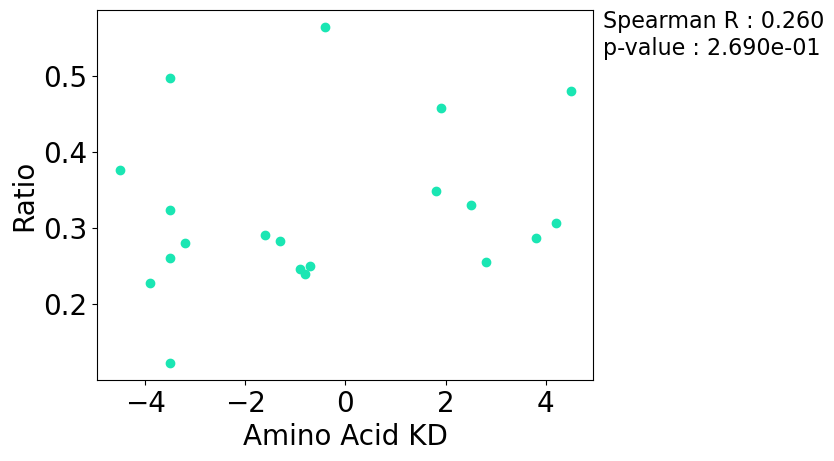

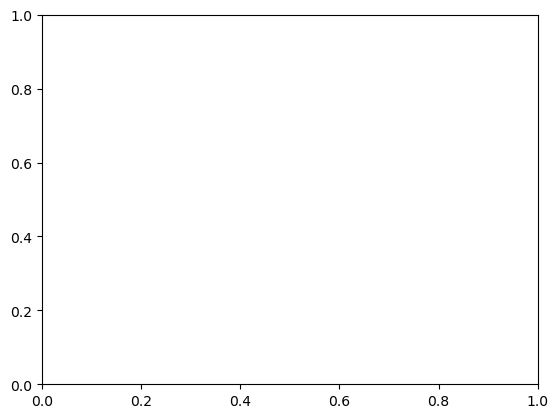

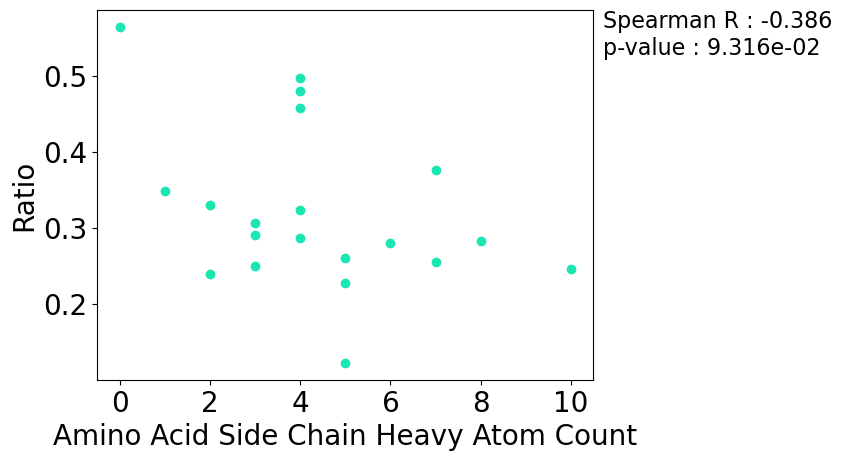

SignificanceResult(statistic=0.22026645449672183, pvalue=0.36486273693786087)


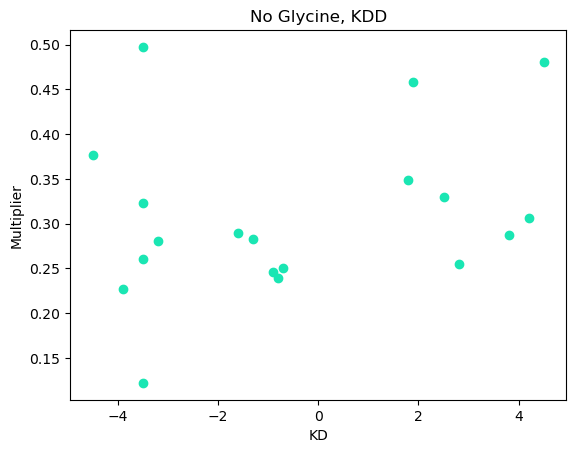

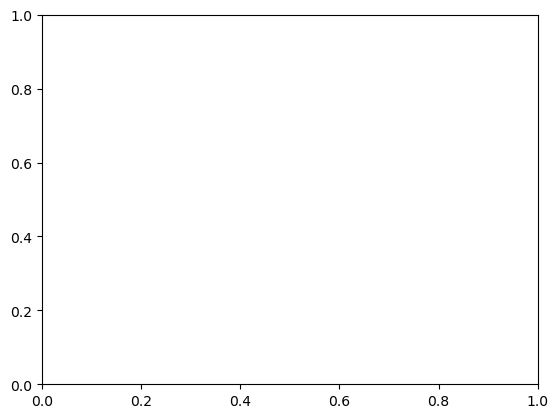

In [142]:
#Significance test of aa differences
#Ref https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets
#Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
under_2_list = [binding_site_dictionary["under_2"][a] for a in list_aas]
over_2_list = [binding_site_dictionary["over_2"][a] for a in list_aas]
summed_list = [binding_site_dictionary["under_2"][a] + binding_site_dictionary["over_2"][a] for a in list_aas]

#Normalized list
norm_u_2 = 1000.0 * np.array(under_2_list) / np.sum(under_2_list)
norm_o_2 = 1000.0 * np.array(over_2_list) / np.sum(over_2_list)

#Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
#But different overall counts
print(scipy.stats.chisquare(norm_u_2, norm_o_2))
print(scipy.stats.chisquare(norm_o_2, norm_u_2))
print(stats.ks_2samp(under_2_list, over_2_list))

#Does aa chemistry affect partitioning?
print("AA Under 2 freq Over 2 freq Multiplier")
aa_dict_of_mult = {}
for aa in sorted(list_aas):
    print(f"{aa} {binding_site_dictionary['under_2'][aa]} {binding_site_dictionary['over_2'][aa]} {binding_site_dictionary['under_2'][aa] / binding_site_dictionary['over_2'][aa] : .2f}")
    aa_dict_of_mult[aa] = binding_site_dictionary['under_2'][aa] / binding_site_dictionary['over_2'][aa]
    
#Ref https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html
kd_dict = {"ALA" : 1.8,
"CYS" : 2.5,
"ASP" : -3.5,
"GLU" : -3.5,
"PHE" : 2.8,
"GLY" : -0.4,
"HIS" : -3.2,
"ILE" : 4.5,
"LYS" : -3.9,
"LEU" : 3.8,
"MET" : 1.9,
"ASN" : -3.5,
"PRO" : -1.6,
"GLN" : -3.5,
"ARG" : -4.5,
"SER" : -0.8,
"THR" : -0.7,
"VAL" : 4.2,
"TRP" : -0.9,
"TYR" : -1.3}

atom_count_dict = {"ALA" : 1,
"CYS" : 2,
"ASP" : 4,
"GLU" : 5,
"PHE" : 7,
"GLY" : 0,
"HIS" : 6,
"ILE" : 4,
"LYS" : 5,
"LEU" : 4,
"MET" : 4,
"ASN" : 4,
"PRO" : 3,
"GLN" : 5,
"ARG" : 7,
"SER" : 2,
"THR" : 3,
"VAL" : 3,
"TRP" : 10,
"TYR" : 8}

kd_list = []
ac_list = []
mult_list = []
kd_list_no_gly = []
mult_list_no_gly = []

for aa_pl in list_aas:
    kd_list.append(kd_dict[aa_pl])
    ac_list.append(atom_count_dict[aa_pl])
    mult_list.append(aa_dict_of_mult[aa_pl])
    if aa_pl != "GLY":
        kd_list_no_gly.append(kd_dict[aa_pl])
        mult_list_no_gly.append(aa_dict_of_mult[aa_pl])

        
afh, aph = plt.subplots()
plt.scatter(kd_list, mult_list, color = [0.1, 0.9, 0.7])


#spearman thank you Jeremy for the suggestion!
#ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
#plt.title("all, KD")
plt.xlabel("Amino Acid KD", fontsize = 20)
plt.ylabel("Ratio", fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
print(scipy.stats.spearmanr(kd_list, mult_list))
spearman_r_kd = scipy.stats.spearmanr(kd_list, mult_list)
#Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
#Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
plt.text(1.02, 0.88, f"Spearman R : {spearman_r_kd[0]:.3f}\np-value : {spearman_r_kd[1]:.3e}", transform=aph.transAxes, fontsize = 16)


plt.show()
plt.close()
plt.clf()
plt.cla()


ataf, atap = plt.subplots()

plt.scatter(ac_list, mult_list, color = [0.1, 0.9, 0.7])


plt.xlabel("Amino Acid Side Chain Heavy Atom Count", fontsize = 20)
plt.ylabel("Ratio", fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
#spearman thank you Jeremy for the suggestion!
#ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
#plt.title("atom count")
spearman_r_ac = scipy.stats.spearmanr(ac_list, mult_list)
#Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
#Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
plt.text(1.02, 0.88, f"Spearman R : {spearman_r_ac[0]:.3f}\np-value : {spearman_r_ac[1]:.3e}", transform=atap.transAxes, fontsize = 16)

plt.show()
plt.close()
plt.clf()
plt.cla()

plt.scatter(kd_list_no_gly, mult_list_no_gly, color = [0.1, 0.9, 0.7])

#spearman thank you Jeremy for the suggestion!
#ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
print(scipy.stats.spearmanr(kd_list_no_gly, mult_list_no_gly))
plt.title("No Glycine, KDD")
plt.xlabel("KD")
plt.ylabel("Multiplier")
plt.show()
plt.close()
plt.clf()
plt.cla()


In [138]:
for d in range(0, len(df_pdb)): print(f'name {df_pdb["names"][d]} rmsd {df_pdb["top_rmsd"][d]} conf {df_pdb["top_confidence"][d]} nearby W {df_pdb["NearbyW"][d]}')

name 6qqw rmsd 0.9898587811095729 conf 0.275576114654541 nearby W 1
name 6d08 rmsd 3.306565374152745 conf -2.1367692947387695 nearby W 1
name 6jap rmsd 2.7590960538054117 conf -1.0503170490264893 nearby W 0
name 6np2 rmsd 3.348641186414294 conf -1.3641011714935303 nearby W 13
name 6uvp rmsd 0.8940085852296085 conf 0.940610945224762 nearby W 20
name 6oxq rmsd 0.9020278517762146 conf 0.49125978350639343 nearby W 10
name 6jsn rmsd 1.1547994564029826 conf 0.7386958003044128 nearby W 1
name 6hzb rmsd 4.7740320294565555 conf -1.8337191343307495 nearby W 88
name 6qrc rmsd 4.039643233744244 conf -0.047578223049640656 nearby W 2
name 6oio rmsd 16.050483436077002 conf -0.8117192983627319 nearby W 4
name 6jag rmsd 5.521851884152145 conf -1.0346876382827759 nearby W 0
name 6moa rmsd 0.46929031791663567 conf 0.6868524551391602 nearby W 8
name 6hld rmsd 9.207651108934957 conf -2.3005614280700684 nearby W 0
name 6i9a rmsd 6.475661774582021 conf -2.2627904415130615 nearby W 8
name 6e4c rmsd 1.66346837

In [143]:
rdkit.__version__

'2022.03.5'